In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from string import ascii_letters
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
import cddm_data_simulation as cds
import boundary_functions as bf

# Set styles
sns.set(style = "white")

ModuleNotFoundError: No module named 'seaborn'

In [2]:
# SUPPORT FUNCTIONS DATA PROCESSING
def collect_datasets(files = ['a', 'b'],
                     burn_in = 1000,
                     sort_ = True):
    dats = []
    for file_ in files:
        dats.append(pickle.load(open(file_ , 'rb')))

    dat_tmp_0 = []
    dat_tmp_1 = []
    for dat in dats:
        dat_tmp_0.append(dat[0])
        dat_tmp_1.append(dat[2])

    dat_total = [np.concatenate(dat_tmp_0, axis = 0), np.concatenate(dat_tmp_1, axis = 0)]


    # Sort by first column in parameters
    if sort_ == True:
        ind = np.argsort(dat_total[0][:, 0])
        dat_total[0] = dat_total[0][ind]
        dat_total[1] = dat_total[1][ind]

    # Calculate posterior means
    means = np.mean(dat_total[1][:, burn_in:, :], axis = (1))
    
    return (dat_total, means)

def get_r2_vec(estimates = [0, 0, 0],
               ground_truths = [0, 0, 0]):
    
    r2_vec = []
    for i in range(estimates.shape[1]):
        reg = LinearRegression().fit(np.asmatrix(estimates[:, i]).T, np.asmatrix(ground_truths[:, i]).T)
        r2_vec.append(str(round(reg.score(np.asmatrix(estimates[:, i]).T, np.asmatrix(ground_truths[:, i]).T), 2)))
    return r2_vec

In [5]:
# SUPPORT FUNCTIONS GRAPHS
def parameter_recovery_plot(ax_titles = ['v', 'a', 'w', 'ndt', 'angle'], 
                            title = 'Parameter Recovery: ABC-NN',
                            ground_truths = [0, 0, 0],
                            estimates = [0, 0, 0],
                            r2_vec = [0, 0, 0],
                            cols = 3):
    
    rows = int(np.ceil(len(ax_titles) / cols))

    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)
    fig.suptitle(title, fontsize = 40)

    sns.despine(right = True)

    for i in range(estimates.shape[1]):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        sns.regplot(ground_truths[:, i], estimates[:, i], 
                    color = 'black', 
                    marker =  '+',
                    ax = ax[row_tmp, col_tmp],
                    scatter_kws = {'s': 120, 'alpha': 0.5})
        ax[row_tmp, col_tmp].text(0.7, 0.1, '$R^2$: ' + r2_vec[i], 
                                  transform = ax[row_tmp, col_tmp].transAxes, 
                                  fontsize = 20)
        ax[row_tmp, col_tmp].set_xlabel(ax_titles[i] + ' - ground truth', 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].set_ylabel(ax_titles[i] + ' - posterior mean', 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].tick_params(axis = "x", 
                                         labelsize = 24)

    for i in range(estimates.shape[1], rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    plt.setp(ax, yticks = [])
    return plt.show()


def trace_plots(ax_titles = ['v', 'a', 'w', 'ndt', 'angle'],
                param_lims = [(-2, 2), (0.5, 2), (0.3,0.7), (0.0, 1.0), (0.0, 1.4)],
                title = 'Trace Plots',
                posterior_samples = [0, 0, 0],
                ground_truths = [0, 0, 0],
                trace_id = 1,
                cols = 3):
    
    T = posterior_samples.shape[1]
    rows = int(np.ceil(len(ax_titles) / cols))

    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True)

    fig, ax = plt.subplots(rows, 
                           cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)

    sns.despine(right = True)

    for i in range(posterior_samples.shape[2]):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        sns.lineplot(data = posterior_samples[trace_id, :, i], 
                     color = 'black', 
                     ax = ax[row_tmp, col_tmp])
        ax[row_tmp, col_tmp].axhline(y = ground_truths[trace_id, i], color = 'red')
        ax[row_tmp, col_tmp].set_ylim(param_lims[i])
        ax[row_tmp, col_tmp].set_title(ax_titles[i], fontsize = 24)
        ax[row_tmp, col_tmp].tick_params(axis = "x", 
                                         labelsize = 24)
        ax[row_tmp, col_tmp].tick_params(axis = "y", 
                                         labelsize = 24)

    for i in range(posterior_samples.shape[2], rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    #plt.setp(ax, yticks = [])
    plt.tight_layout()
    
    
def correlation_hist_plot(data = [0, 0, 0],
                          ax_titles = ['v', 'a', 'w', 'ndt', 'angle']): 
    
    # Plot histograms of correlations between parameters
    # Get array of correlation matrices for all plots
    corr_mat_array = np.zeros((data[1].shape[0], data[0].shape[1], data[0].shape[1]))   
    for i in range(data[1].shape[0]):
        corr_mat_array[i, :, :] = pd.DataFrame(data[1][i, : ,:], columns = ax_titles).corr()

    grid_size = corr_mat_array.shape[2] - 1

    fig, ax = plt.subplots(grid_size, grid_size, 
                           figsize = (20, 20), 
                           sharex = True, 
                           sharey = True)

    fig.suptitle('Posterior Correlations Between Parameters', fontsize = 40)
    grayscale_map = plt.get_cmap('YlGn')

    normalized_params = np.zeros(data[0].shape)
    for i in range(corr_mat_array.shape[1]):
        normalized_params[:, i] = (data[0][:, i] - np.min(data[0][:, i])) \
        / (np.max(data[0][:, i]) - np.min(data[0][:, i]))


    for i in range(grid_size):
        for j in range(grid_size):
            if j > i:
                ax[i, j].axis('off')
            else:
                sns.distplot(corr_mat_array[:, - (i + 2), - (j + 1)], 
                             bins = 20,
                             color = 'black',
                             norm_hist = True,
                             kde = True,
                             rug = True,
                             rug_kws = {"c": grayscale_map(normalized_params[:,  - (j + 1)]), 
                                        'alpha': 0.3},
                             ax = ax[i, j])

                if j == 0:
                    ax[i, j].set_ylabel(ax_titles[- (i + 2)], 
                                        fontsize = 24);
                    ax[i, j].tick_params(axis = "y", 
                                         labelsize = 20)
                if i == (grid_size - 1):
                    ax[i, j].set_xlabel(ax_titles[- (j + 1)], 
                                        fontsize = 24);
                    ax[i, j].tick_params(axis = "x", 
                                         labelsize = 20)

    ax[i, j].set_yticks(ax[i, j].get_yticks()[::2])                
    #plt.tight_layout()
    plt.tight_layout(rect = [0, 0.03, 1, 0.9])
    
def get_posterior_variances(data = [0, 0, 0],
                            ax_titles = ['v', 'a', 'w', 'ndt']):
    
    # MLP
    var_data = np.array(np.zeros((data[0].shape[0], data[0].shape[1])))
    
    for i in range(data[0].shape[0]):
        var_data[i, :] = np.diag(pd.DataFrame(data[1][i, : ,:], columns = ax_titles).cov())
    return var_data

    
def posterior_variance_comparison_hist(var_data_1 = [],
                                       var_data_2 = [],
                                       var_data_1_title = '..',
                                       var_data_2_title = '..',
                                       ax_titles = ['v', 'a', 'w', 'ndt', 'angle'],
                                       cols = 3):  

    rows = int(np.ceil(len(ax_titles) / cols))

    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = True)
    fig.suptitle('Posterior variance: ' + var_data_1_title + ' vs. ' + var_data_2_title + ' (Histogram)', 
                 fontsize = 40)
    sns.despine(right = True)

    x_title = '$\ln \sigma^2_{' + var_data_1_title + '} - \ln \sigma^2_{' + var_data_2_title + '}$'

    for i in range(var_data_1.shape[1]):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)

        sns.distplot(np.log((var_data_1[:, i])) -  np.log((var_data_2[:, i])), 
                     bins = 20,
                     color = 'black',
                     norm_hist = True,
                     kde = False,
                     rug = False,
                     #rug_kws = {"c": grayscale_map(dat_total[0][:, j]), 'alpha': 0.3},
                     ax = ax[row_tmp, col_tmp])

        ax[row_tmp, col_tmp].set_xlabel(x_title, 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].tick_params(axis = "x", 
                                         labelsize = 24)
        ax[row_tmp, col_tmp].tick_params(axis = "y",
                                         labelsize = 24)
        ax[row_tmp, col_tmp].set_title(ax_titles[i], fontsize = 24)

    for i in range(var_data_1.shape[1], rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    plt.tight_layout(rect = [0, 0.03, 1, 0.9])
    #plt.show()
    

def posterior_variance_comparison_reg(var_data_1 = [],
                                      var_data_2 = [],
                                      params = [], # need params here because we used normalize params to color graphs
                                      var_data_1_title = '..',
                                      var_data_2_title = '..',
                                      ax_titles = ['v', 'a', 'w', 'ndt', 'angle'],
                                      cols = 3):  
    # 
    rows = int(np.ceil(len(ax_titles) / cols))

    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)

    fig.suptitle('Posterior variance: ' + var_data_1_title + ' vs. ' + var_data_2_title + ' (Histogram)', 
                 fontsize = 40)
    sns.despine(right = True)

    x_title = '$\ln \sigma^2_{' + var_data_1_title + '} - \ln \sigma^2_{' + var_data_2_title + '}$'

    # Get normalized parameters for coloring purposes
    normalized_params = np.zeros(params.shape)
    for i in range(params.shape[1]):
        normalized_params[:, i] = (params[:, i] - np.min(params[:, i])) \
        / (np.max(params[:, i]) - np.min(params[:, i]))

    for i in range(params.shape[1]):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        sns.regplot(np.log(var_data_1[:, i]), np.log(var_data_2[:, i]),
                    marker =  '+',
                    ax = ax[row_tmp, col_tmp],
                    scatter_kws = {'s': 120, 
                                   'alpha': 0.5,
                                   'color': grayscale_map(normalized_params[:, i])},
                    line_kws = {'color': 'black'})

        xlabel_tmp = '$ \ln(\sigma^2_{' +  var_data_1_title  + '})$: ' + ax_titles[i]
        ylabel_tmp = '$ \ln(\sigma^2_{' +  var_data_2_title  + '})$: ' + ax_titles[i]
        
        ax[row_tmp, col_tmp].set_xlabel(xlabel_tmp, 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].set_ylabel(ylabel_tmp, 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].tick_params(axis = "x", 
                                         labelsize = 24)
        ax[row_tmp, col_tmp].tick_params(axis = "y", 
                                         labelsize = 24)

    for i in range(params.shape[1], rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    #plt.setp(ax, yticks = [])
    plt.tight_layout(rect = [0, 0.03, 1, 0.9])
    #plt.show()

In [4]:
# REMAINING META

# DDM Angle
ax_titles_angle = ['v', 'a', 'w', 'ndt', 'angle']
param_lims_angle = [(-2, 2), (0.5, 2), (0.3,0.7), (0.0, 1.0), (0.0, 1.4)]

# DDM
ax_titles_ddm = ['v', 'a', 'w', 'ndt']
param_lims_ddm = [(-2, 2), (0.5, 2), (0.3,0.7), (0.0, 1.0)]

# LBA
ax_titles_lba = ['v_0', 'v_1', 'A', 'b', 's', 'ndt']
param_lims_lba = [(1, 2), (1, 2), (0, 1), (1.5, 3), (0.1, 0.2), (0, 1)]

# WEIBULL 
ax_titles_weibull = ['v', 'a', 'w', 'ndt', 'alpha', 'beta']

In [79]:
# META PARAMS: KDE 
method_comparison_folder = "/media/data_cifs/afengler/data/kde/' + weibull_cdf/method_comparison/"
#file_signature  = 'kde_sim_test_ndt'
file_signature = 'post_samp'
burn_in = 1000
file_signature_len = len(file_signature)
files = os.listdir(method_comparison_folder)
files = [method_comparison_folder + file_ for file_ in files if file_[:file_signature_len] == file_signature]

dat_total, means = collect_datasets(files = files,
                                    burn_in = 2500,
                                    sort_ = True)
print(dat_total)
r2_vec = get_r2_vec(estimates = means, 
                   ground_truths = dat_total[0])

mlp_var = get_posterior_variances(data = dat_total, 
                                  ax_titles = ax_titles_weibull)

[array([[-1.50404669,  1.27124951,  0.67910973,  0.42702044,  1.31084638,
         4.7218334 ],
       [-1.49996975,  1.0812037 ,  0.58758097,  0.65140954,  3.57448133,
         5.06213615],
       [-1.49744711,  0.78893256,  0.37765469,  0.16943618,  1.61654402,
         4.35133321],
       ...,
       [ 1.48683972,  1.27905378,  0.51694191,  0.32343196,  4.4406402 ,
         1.96369061],
       [ 1.48901616,  1.29905227,  0.3363563 ,  0.65557947,  1.57778158,
         2.64705741],
       [ 1.48941664,  1.35264476,  0.46147872,  0.58734894,  0.75026378,
         3.33417859]]), array([[[-1.49638522,  1.26201166,  0.65762864,  0.4553348 ,
          1.31231607,  4.62642972],
        [-1.48735099,  1.2575549 ,  0.64798264,  0.45614251,
          1.32633935,  4.6336228 ],
        [-1.49797588,  1.25855958,  0.65224703,  0.46623267,
          1.34476157,  4.63663078],
        ...,
        [-1.39668664,  1.22354618,  0.63598951,  0.47145557,
          2.27065231,  3.02188535],
        [-1.39

In [694]:
# META PARAMS: ANALYTIC
method_comparison_folder = "/media/data_cifs/afengler/data/analytic/ddm/method_comparison/"
file_signature  = 'analytic_sim_test_ndt'
file_signature_len = len(file_signature)
files = os.listdir(method_comparison_folder)
files = [method_comparison_folder + file_ for file_ in files if file_[:file_signature_len] == file_signature]

dat_total_ddm, means_ddm = collect_datasets(files = files,
                                            burn_in = 2500,
                                            sort_ = True)

r2_vec_ddm = get_r2_vec(estimates = means_ddm,
                        ground_truths = dat_total_ddm[0])

analytic_var = get_posterior_variances(data = dat_total_ddm,
                                       ax_titles = ax_titles_ddm)

In [705]:
# META PARAMS: FCN
#deep_inference_file = 'deep_inference_sim_test_ndt_7faf6168-eeaf-11e9-bec8-c72c932a223f.pickle' 
deep_inference_file = 'deep_inference_sim_test_ndt_7d9bfe92-ee08-11e9-a7ea-e3f6145c7f37.pickle'
method_comparison_folder = "/media/data_cifs/afengler/data/kde/ddm/method_comparison/"
dat_total_fcn = pickle.load(open(method_comparison_folder + deep_inference_file, 'rb'))

ind = np.argsort(dat_total_fcn[0][:, 0])
dat_total_fcn[0][:] = dat_total_fcn[0][ind]
dat_total_fcn[1][:, :] = dat_total_fcn[1][ind]
dat_total_fcn[2][:] = dat_total_fcn[2][ind]

# FCN
deep_inference_var = fcn_dat_total[2][:, int(fcn_dat_total[2].shape[1] / 2):]

r2_vec_fcn = get_r2_vec(estimates = dat_total_fcn[2][:, :int(dat_total_fcn[2].shape[1] / 2)],
                        ground_truths = dat_total_fcn[0])

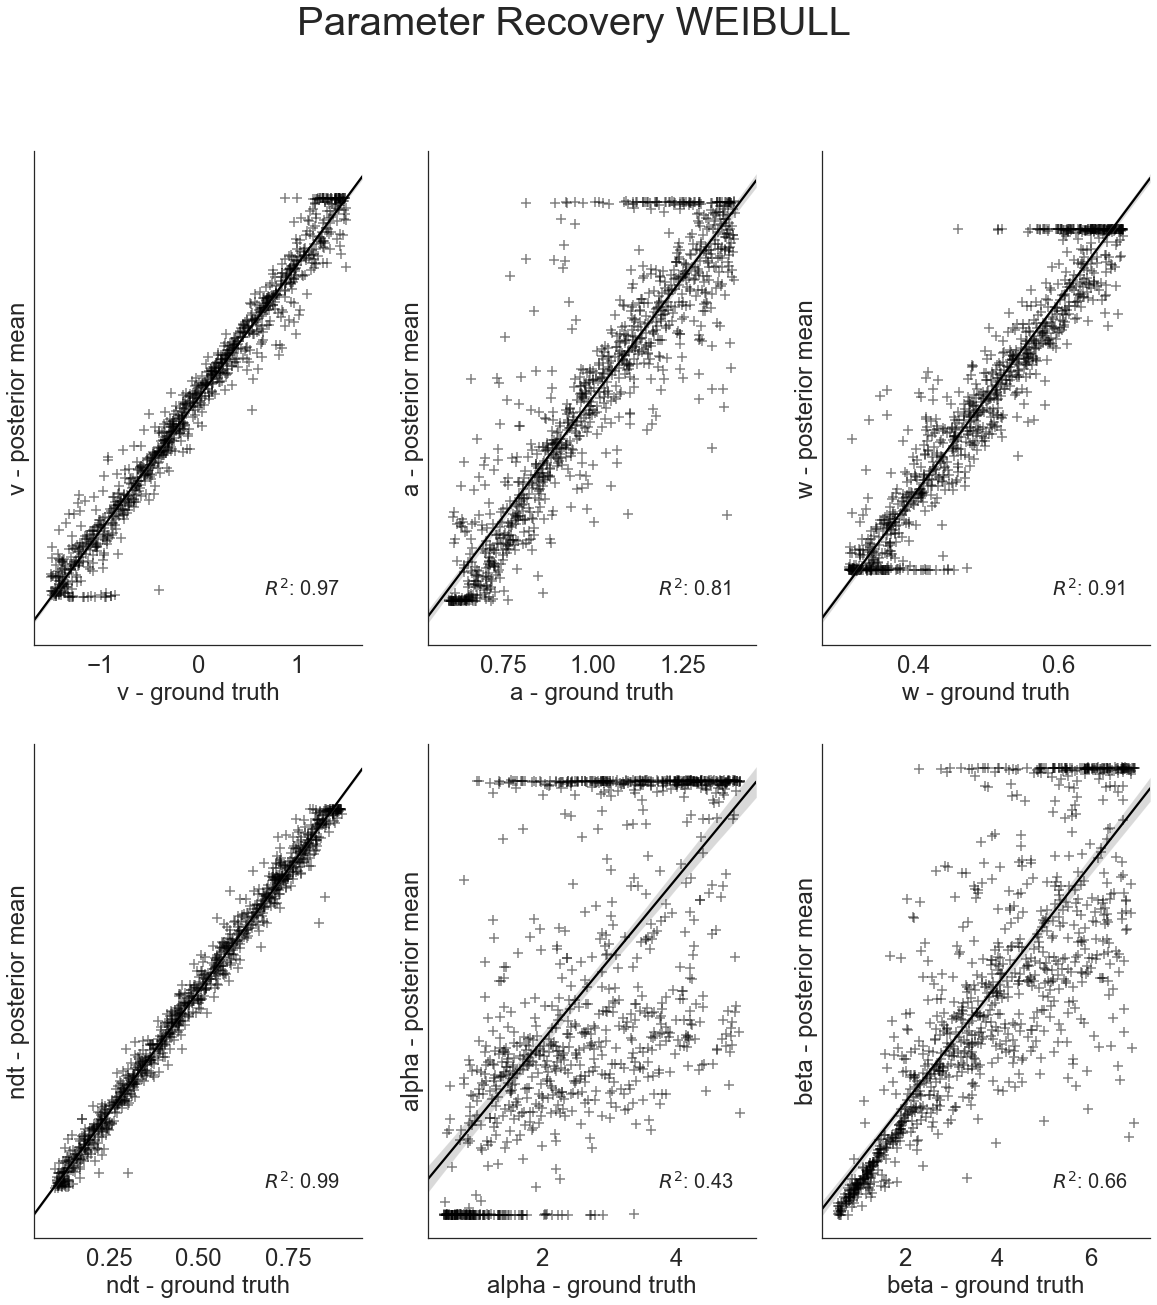

In [80]:
# PARAMETER RECOVERY PLOTS: KDE
parameter_recovery_plot(ax_titles = ax_titles_weibull,
                        title = 'Parameter Recovery WEIBULL',
                        ground_truths = dat_total[0],
                        estimates = means,
                        r2_vec = r2_vec,
                        cols = 3)

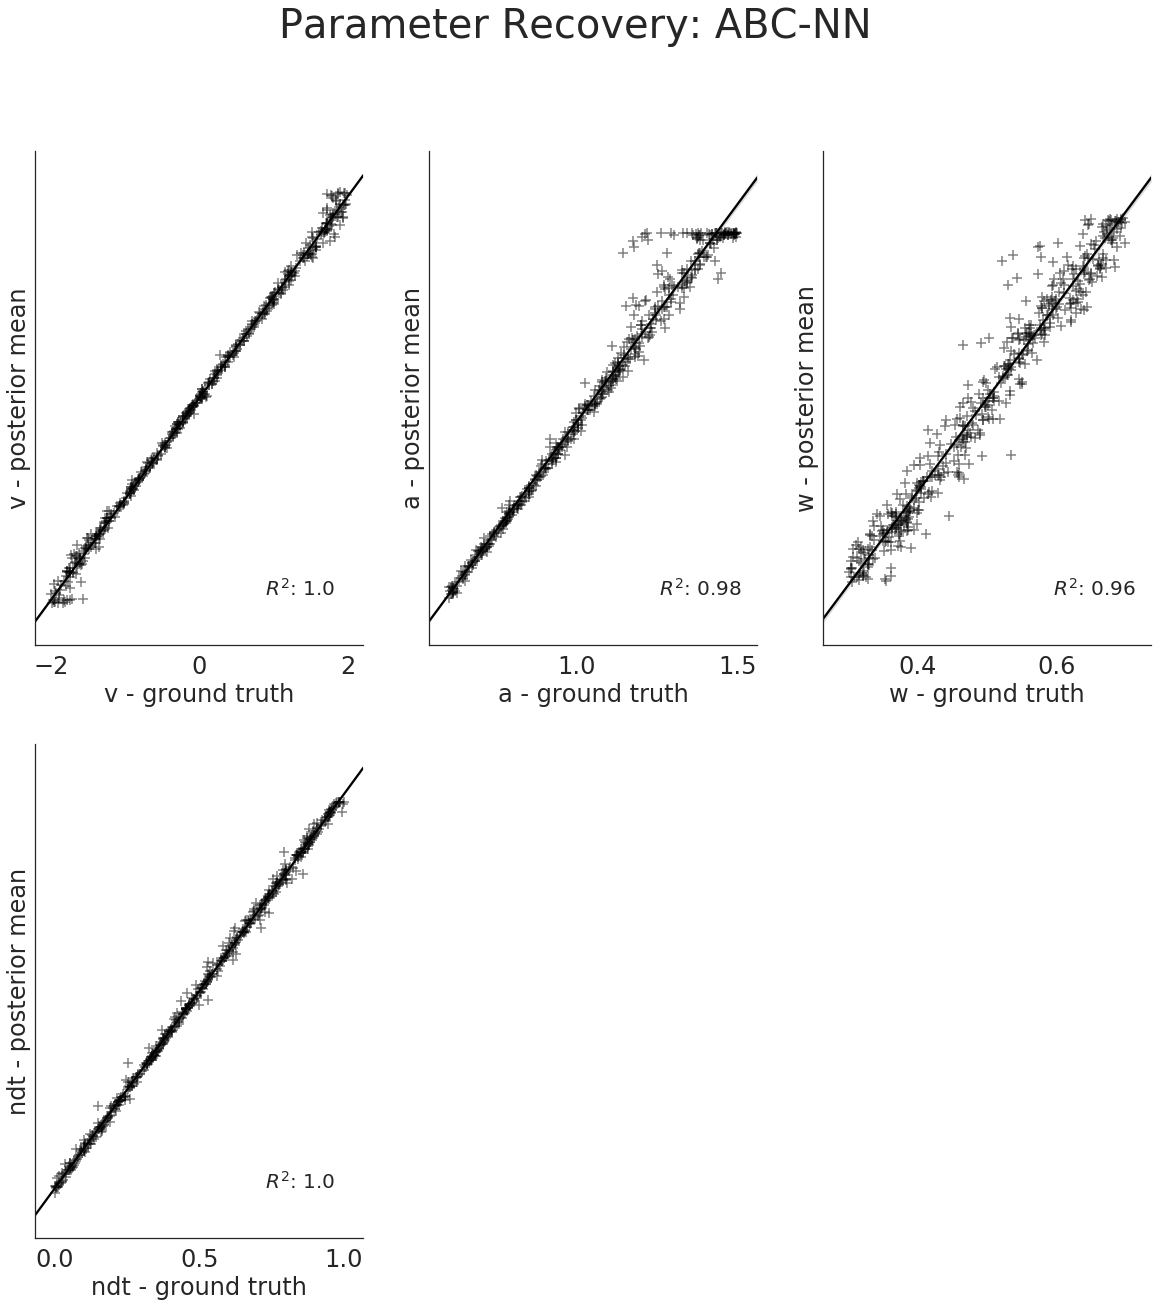

In [703]:
# PARAMETER RECOVERY PLOTS: ANALYTIC
parameter_recovery_plot(ax_titles = ['v', 'a', 'w', 'ndt', 'angle'],
                        title = 'Parameter Recovery: ABC-NN',
                        ground_truths = dat_total_ddm[0],
                        estimates = means_ddm,
                        r2_vec = r2_vec_ddm,
                        cols = 3)

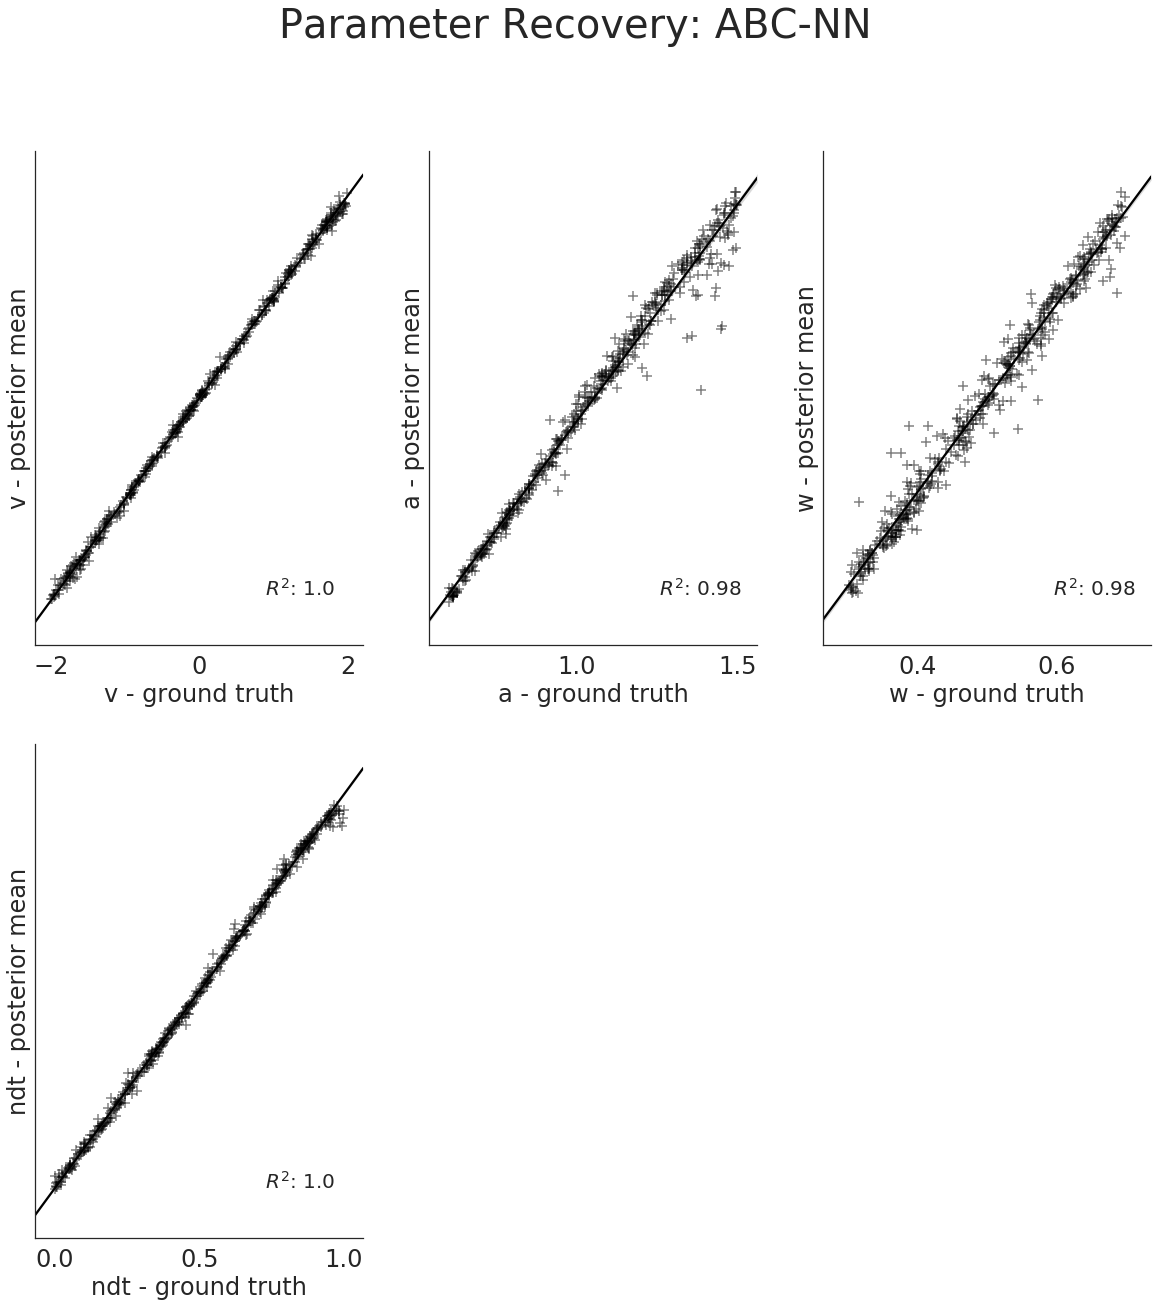

In [709]:
# PARAMETER RECOVERY PLOTS: ANALYTIC
parameter_recovery_plot(ax_titles = ['v', 'a', 'w', 'ndt', 'angle'],
                        title = 'Parameter Recovery: ABC-NN',
                        ground_truths = dat_total_fcn[0],
                        estimates = dat_total_fcn[2][:, :int(dat_total_fcn[2].shape[1] / 2)],
                        r2_vec = r2_vec_fcn,
                        cols = 3)

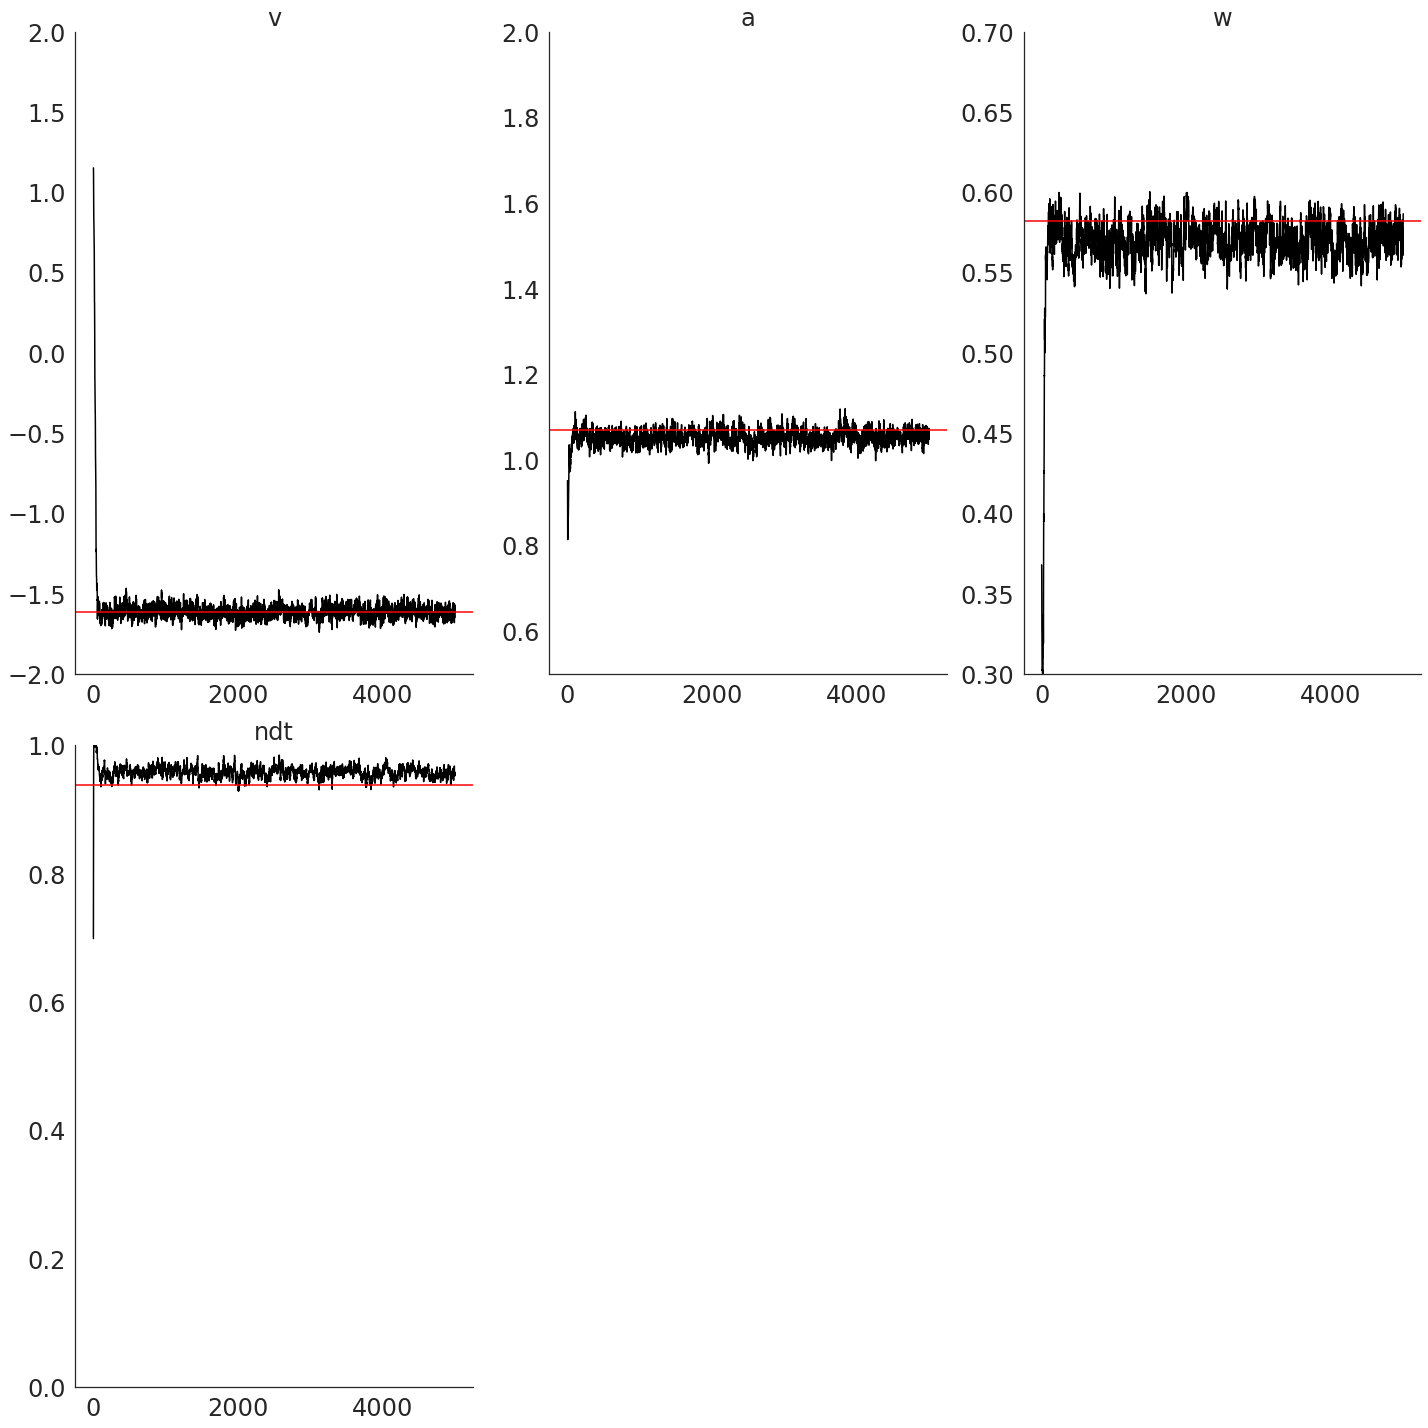

In [717]:
# TRACE PLOTS: KDE
trace_plots(ax_titles = ['v', 'a', 'w', 'ndt', 'angle'],
            param_lims = [(-2, 2), (0.5, 2), (0.3, 0.7), (0.0, 1.0), (0.0, 1.4)],
            title = 'Trace Plots',
            posterior_samples = dat_total[1],
            ground_truths = dat_total[0],
            trace_id = 50,
            cols = 3)

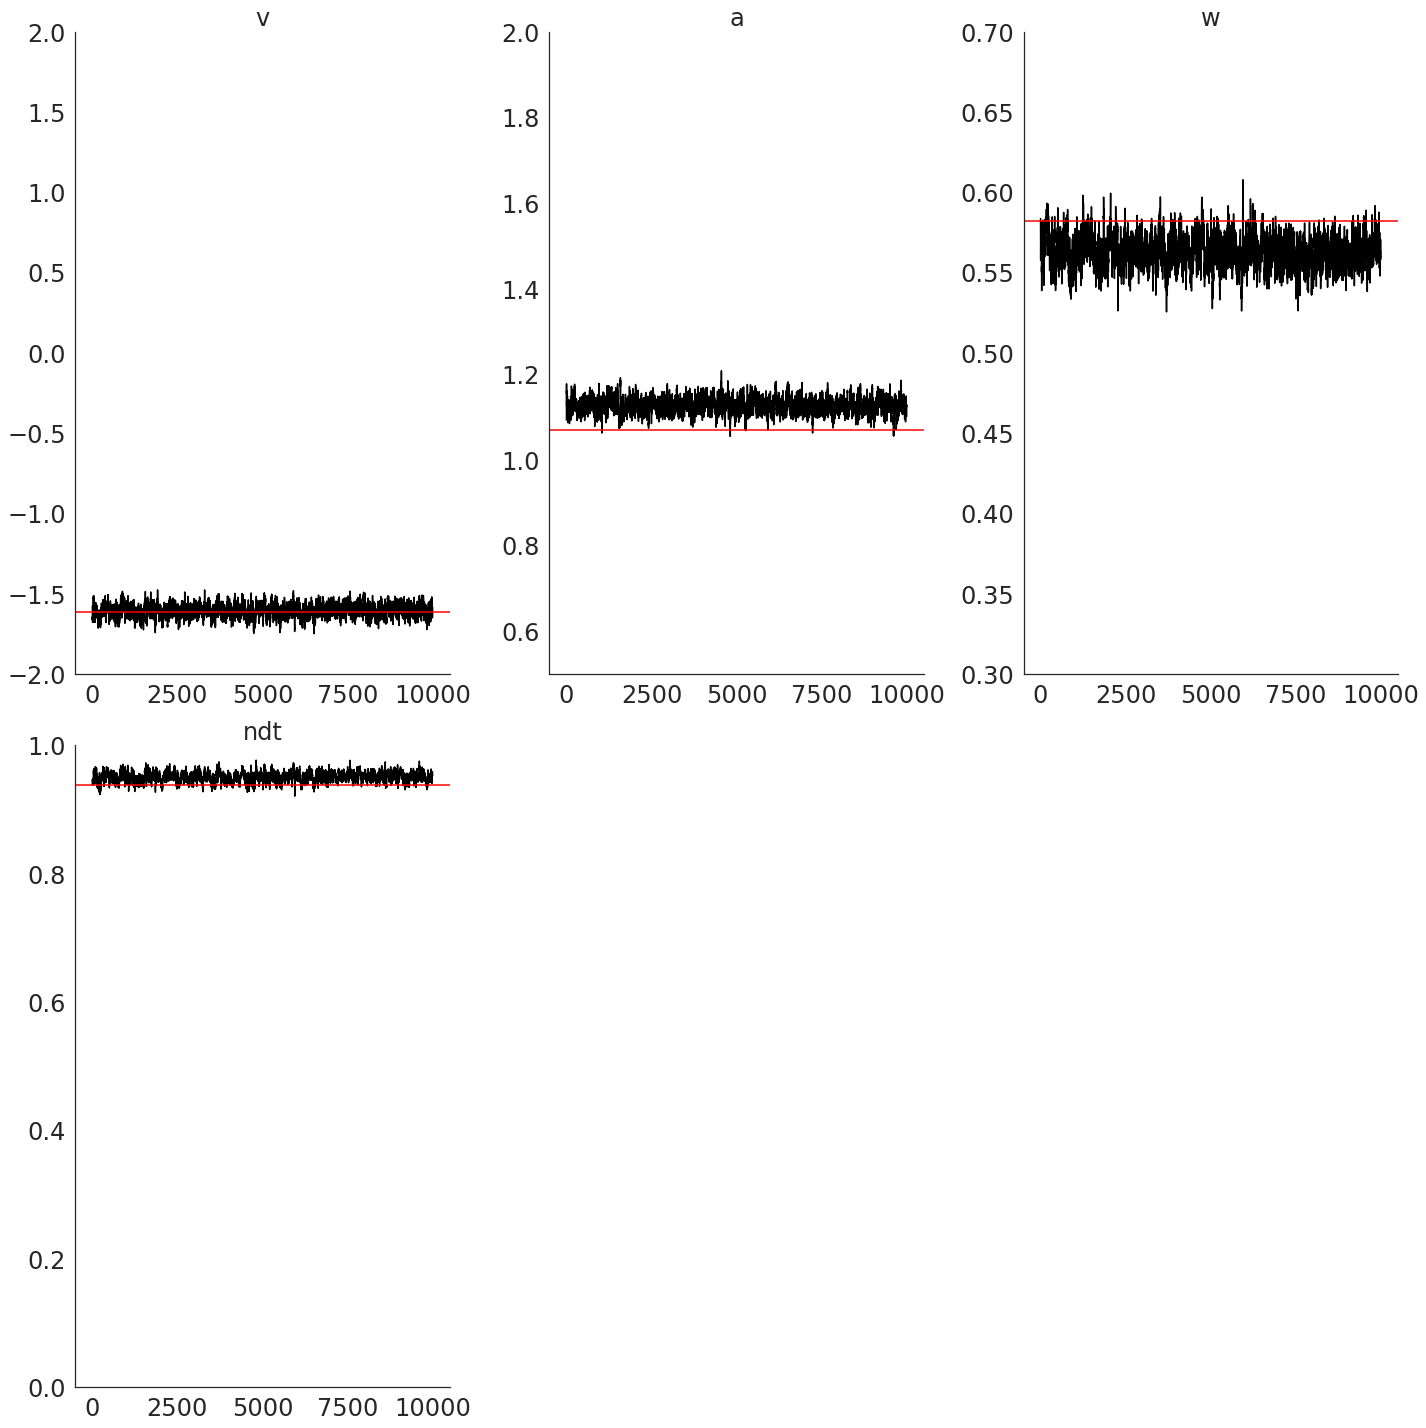

In [718]:
# TRACE PLOTS: ANALYTIC
trace_plots(ax_titles = ['v', 'a', 'w', 'ndt', 'angle'],
            param_lims = [(-2, 2), (0.5, 2), (0.3, 0.7), (0.0, 1.0), (0.0, 1.4)],
            title = 'Trace Plots',
            posterior_samples = dat_total_ddm[1],
            ground_truths = dat_total_ddm[0],
            trace_id = 50,
            cols = 3)

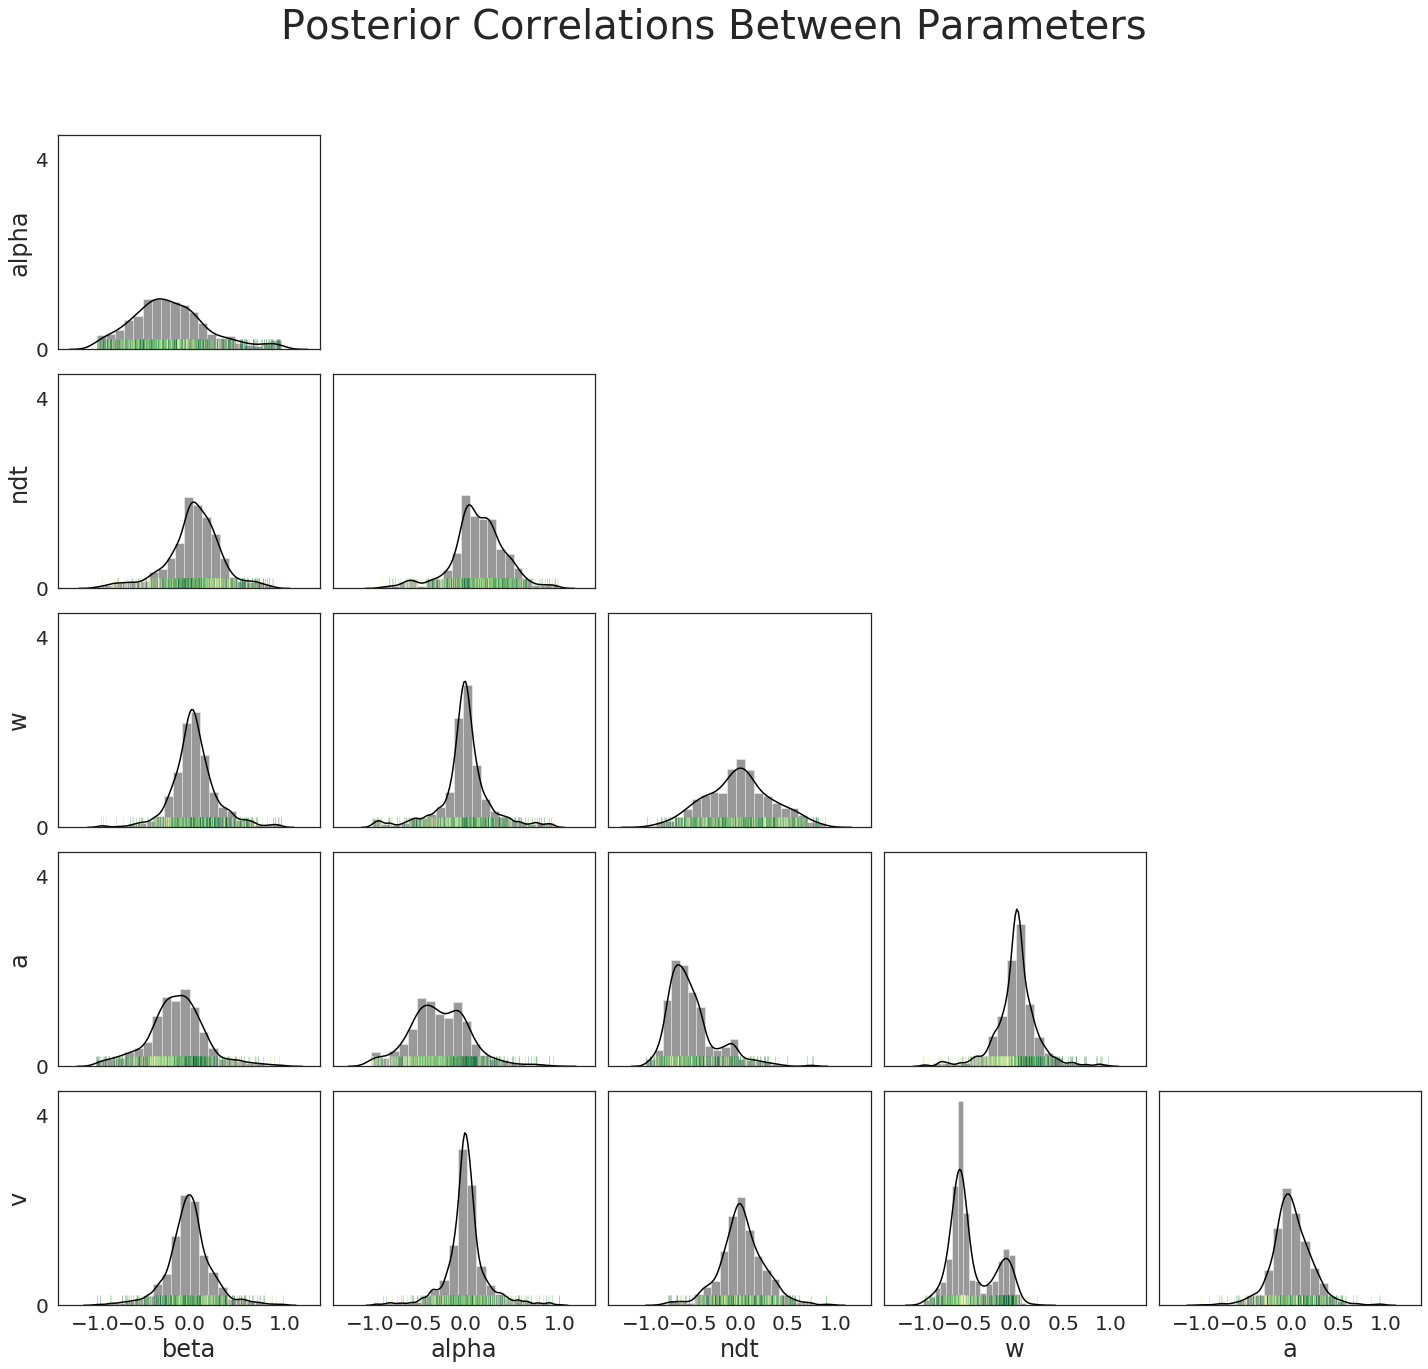

In [845]:
# Correlation Histograms: KDE
correlation_hist_plot(data = dat_total,
                      ax_titles = ax_titles_weibull)

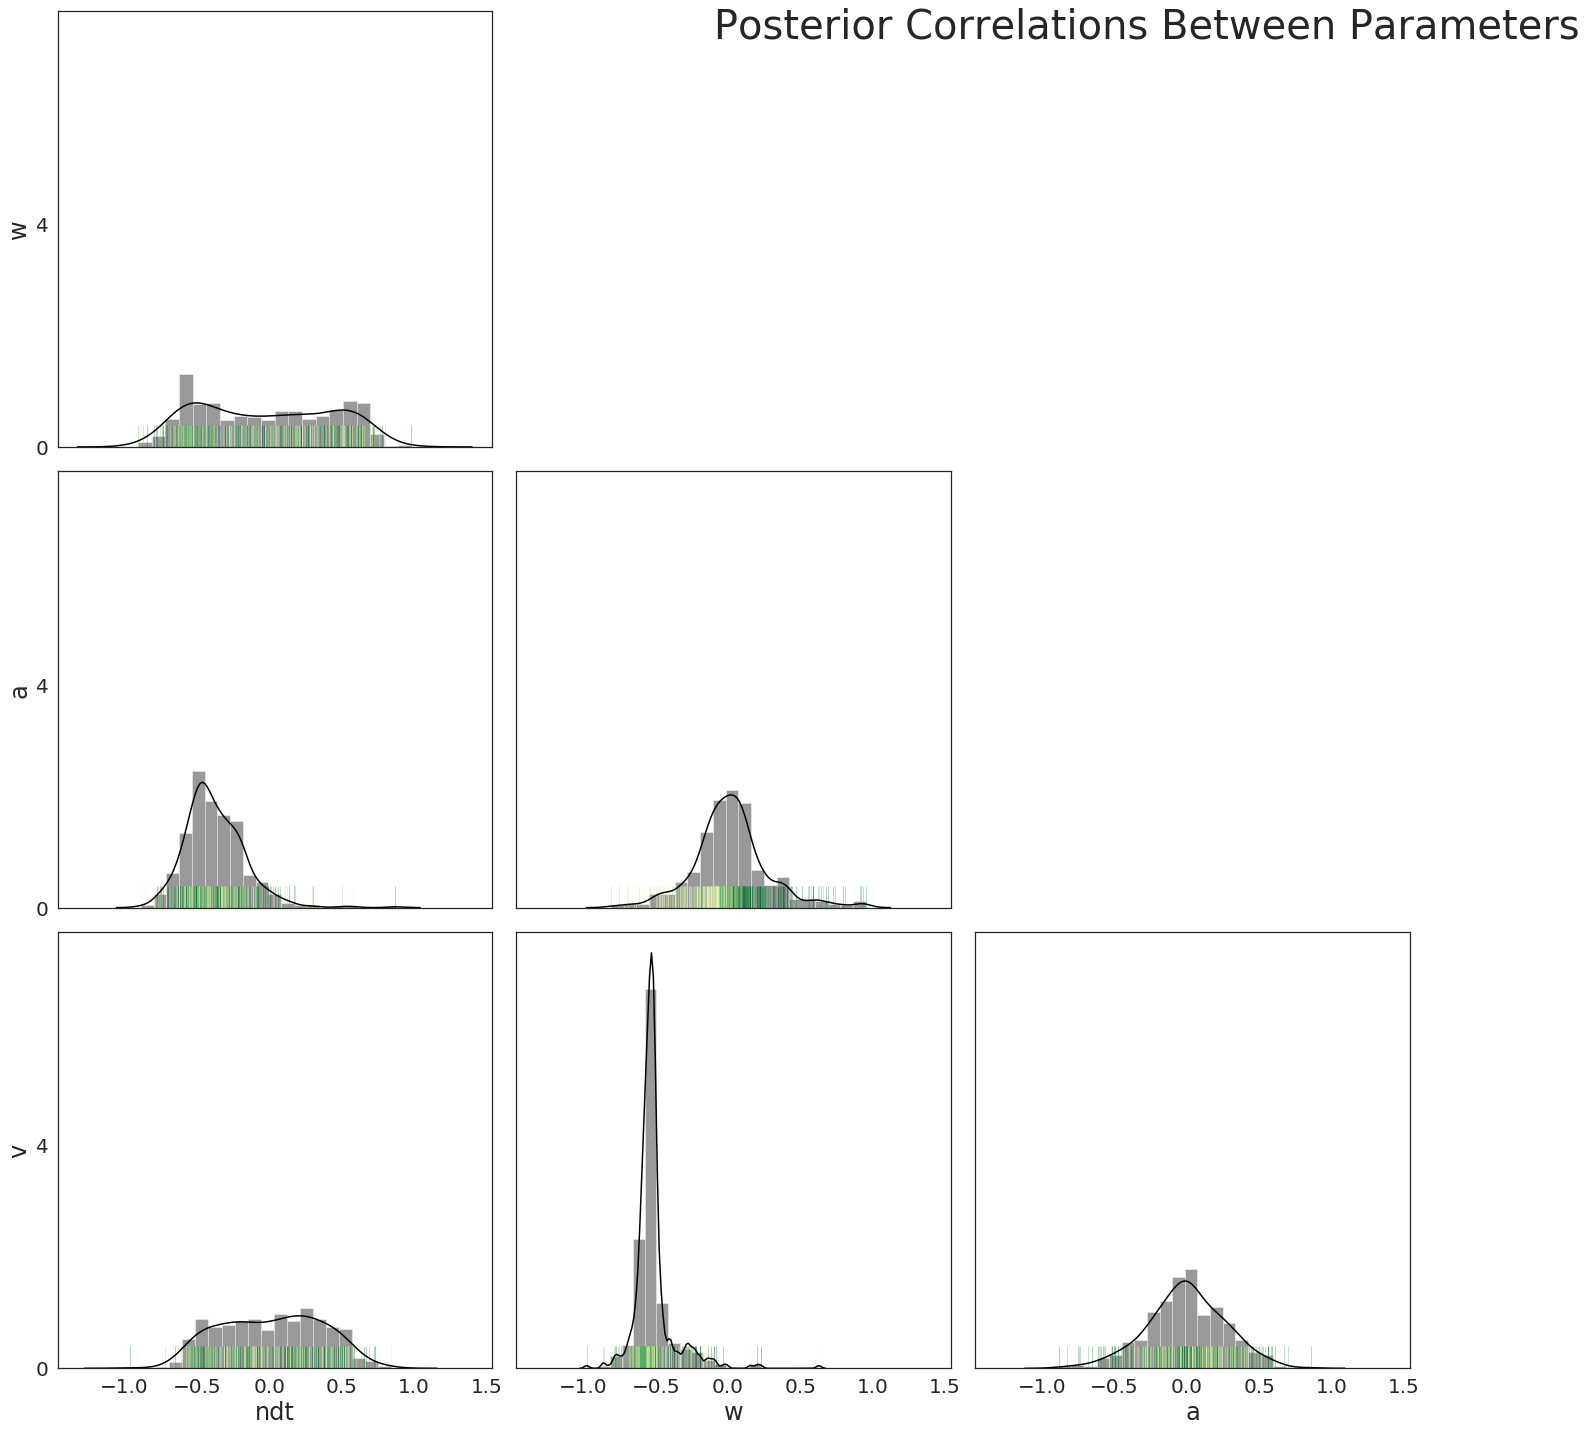

In [756]:
# Correlation Histograms: ANALYTIC
correlation_hist_plot(data = dat_total_ddm,
                      ax_titles = ax_titles_ddm)

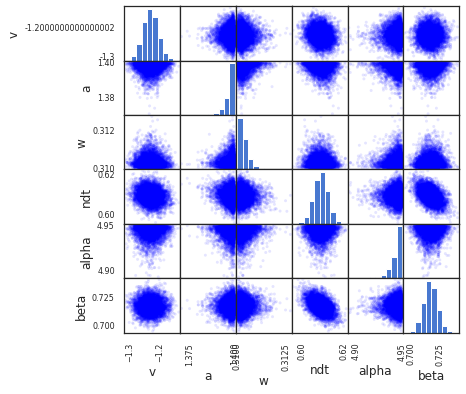

In [851]:
# Scatter matrix Analytical
scatter_matrix(pd.DataFrame(dat_total[1][37, 2500: ,:], columns = ax_titles_weibull), alpha = 0.1, figsize = (6, 6), color = 'blue')
plt.show()

In [852]:
dat_total[0][37]

array([-1.40800053,  0.95108056,  0.32100496,  0.67470776,  4.86023482,
        0.76347547])

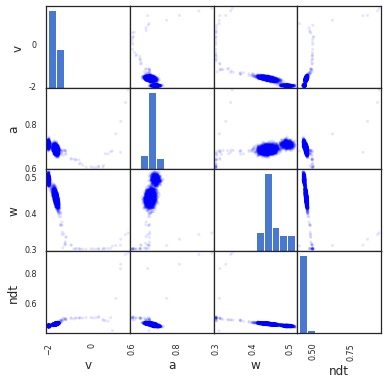

In [616]:
# Scatter matrix Analytical
scatter_matrix(pd.DataFrame(dat_total[1][36, : ,:], columns = ax_titles[:-1]), alpha = 0.1, figsize = (6, 6), color = 'blue')
plt.show()

ValueError: operands could not be broadcast together with shapes (1000,) (500,) 

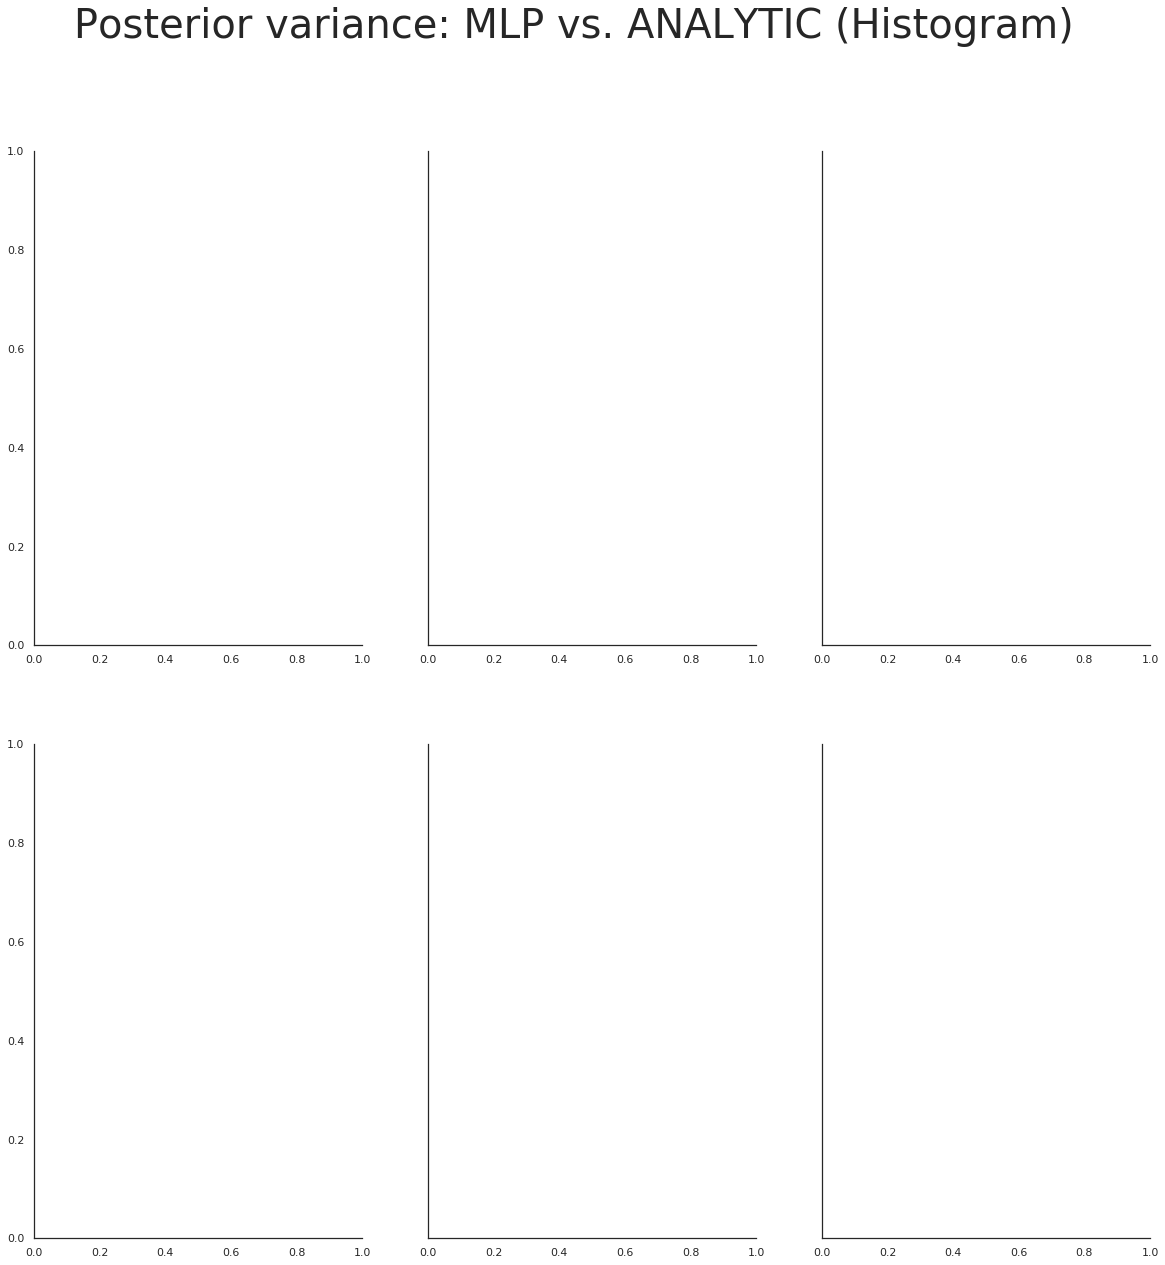

In [856]:
# Posterior variance Histograms: MLP vs. ANALYTIC
posterior_variance_comparison_hist(var_data_1 = mlp_var,
                                   var_data_2 = analytic_var,
                                   var_data_1_title = 'MLP',
                                   var_data_2_title = 'ANALYTIC',
                                   ax_titles = ax_titles_ddm)

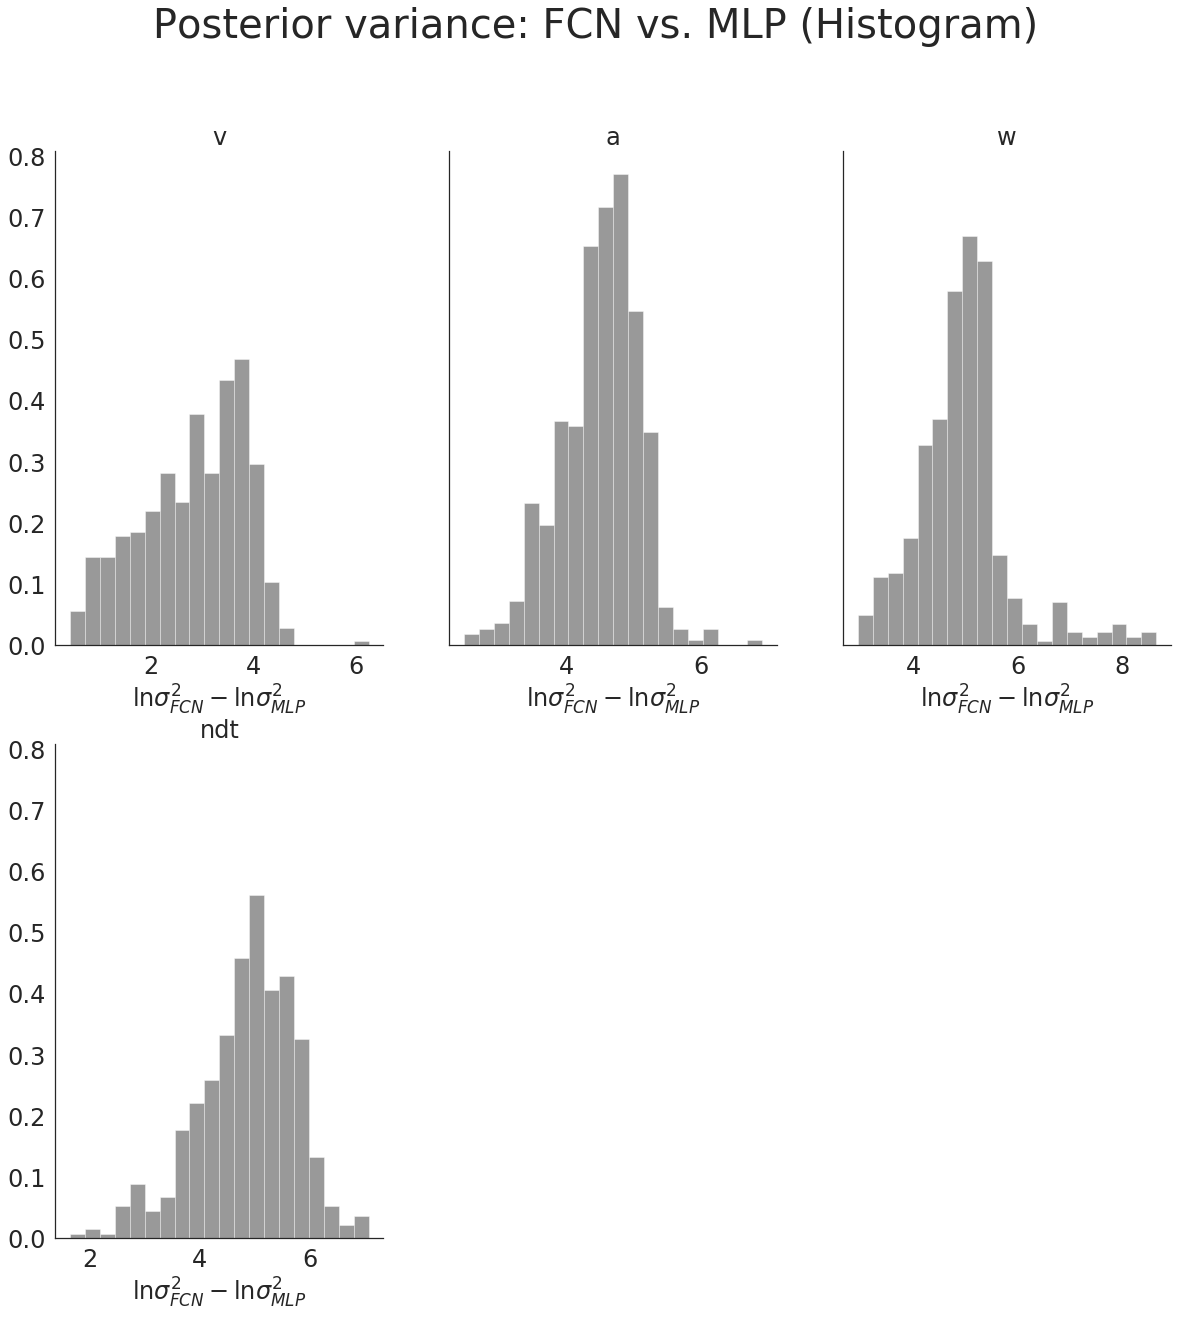

In [785]:
# Posterior variance Histograms: FCN vs. MLP
posterior_variance_comparison_hist(var_data_1 = deep_inference_var,
                                   var_data_2 = mlp_var,
                                   var_data_1_title = 'FCN',
                                   var_data_2_title = 'MLP',
                                   ax_titles = ax_titles_ddm)

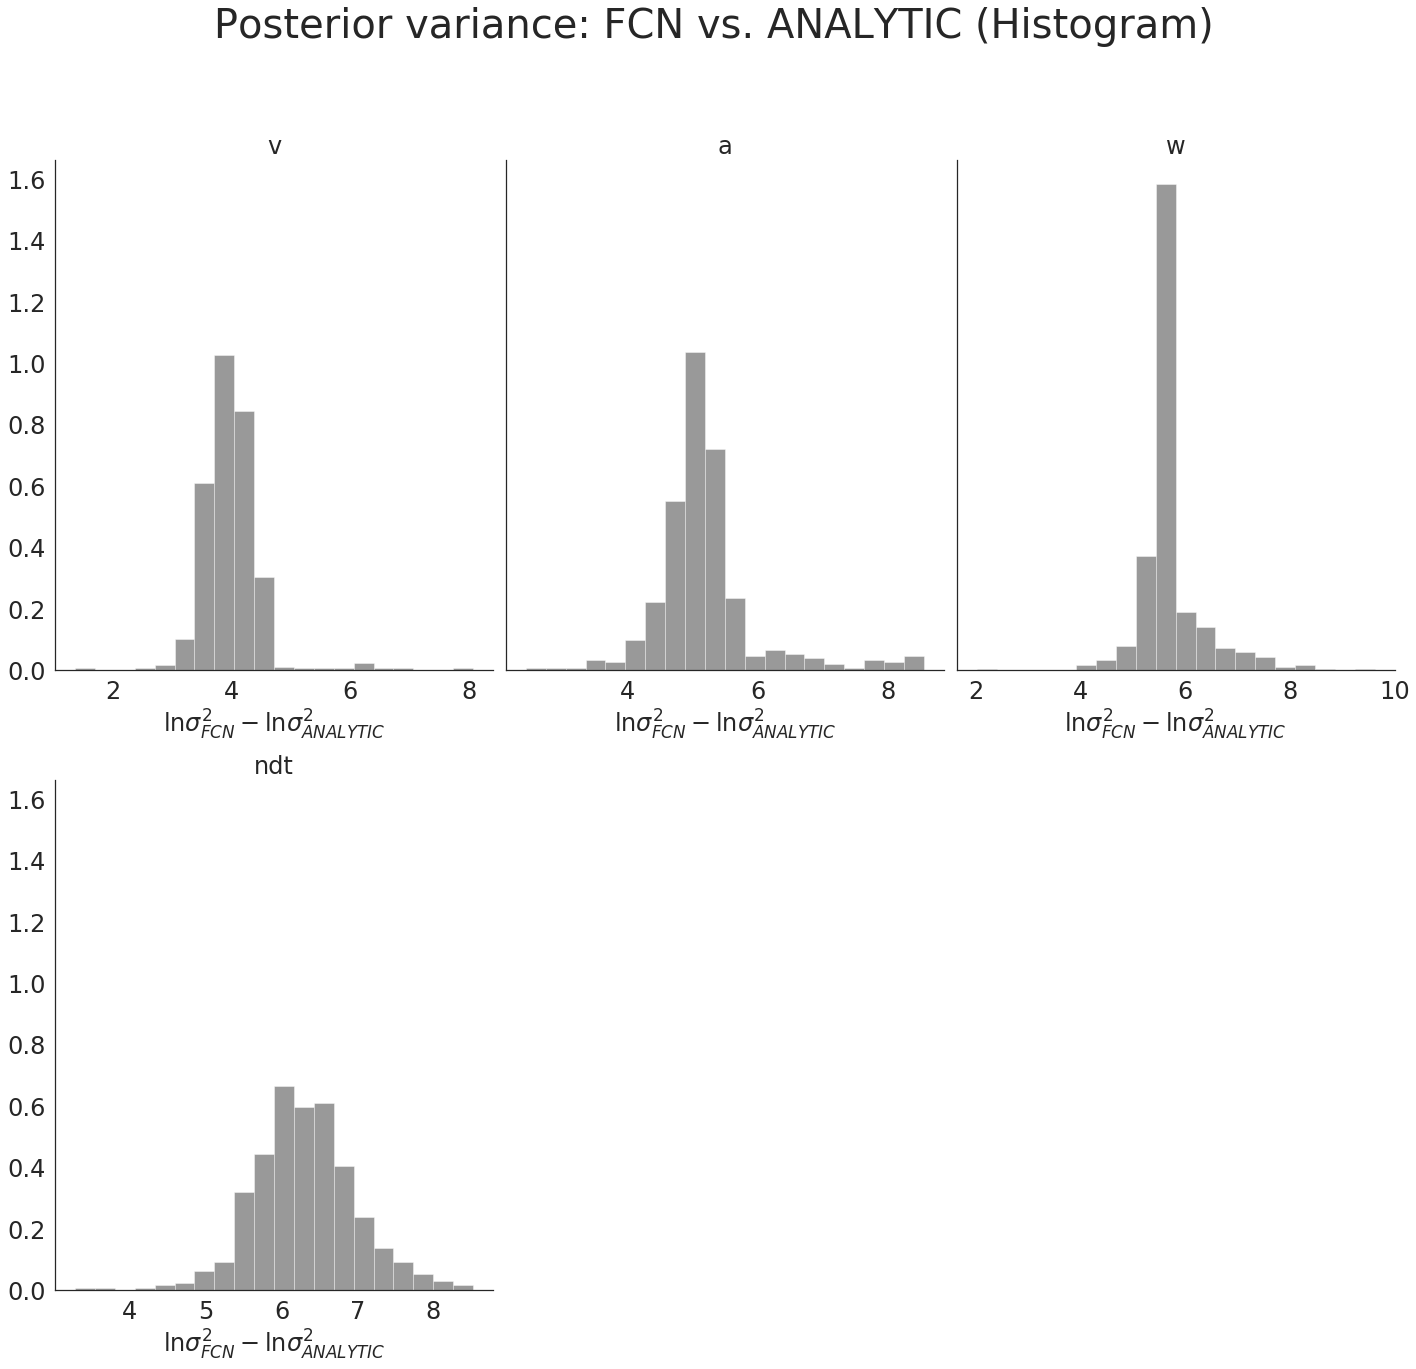

In [855]:
# Posterior variance Histograms: FCN vs. ANALYTIC
posterior_variance_comparison_hist(var_data_1 = deep_inference_var,
                                   var_data_2 = analytic_var,
                                   var_data_1_title = 'FCN',
                                   var_data_2_title = 'ANALYTIC',
                                   ax_titles = ax_titles_ddm)

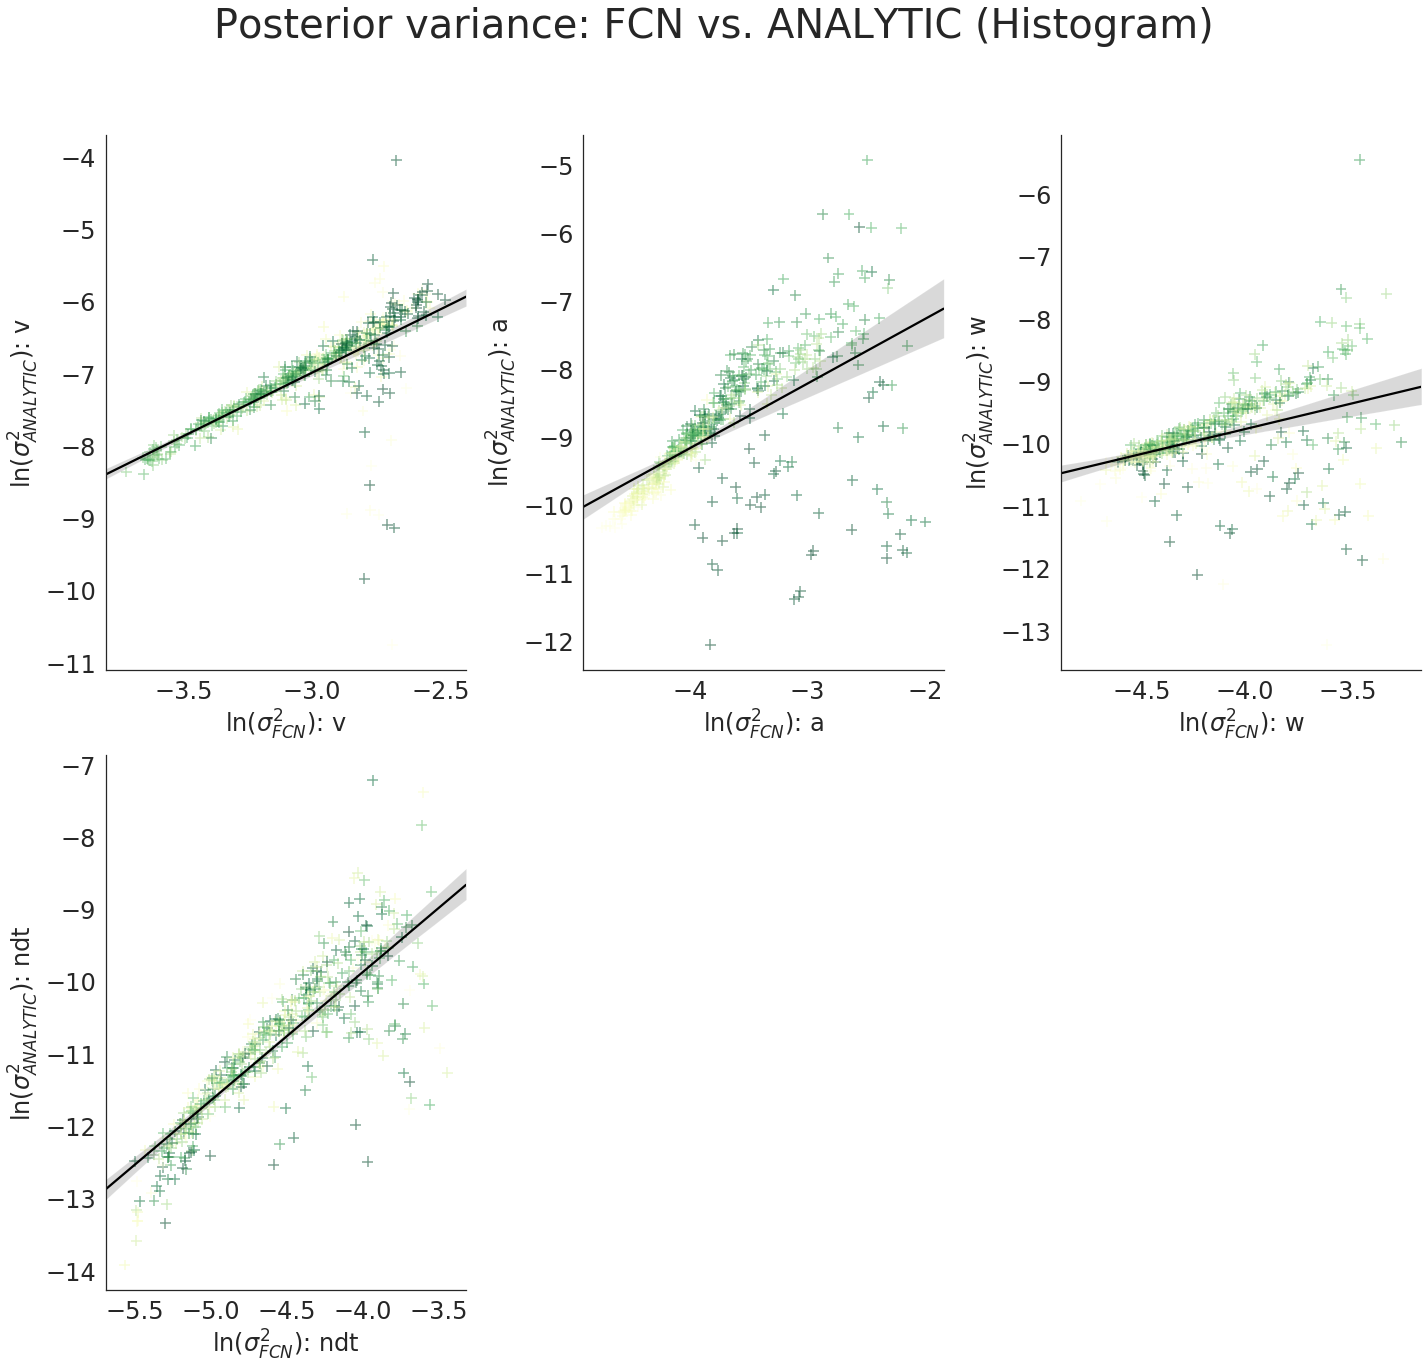

In [795]:
# POSTERIOR VARIANCE REGRESSION: FCN vs. ANALYTIC
posterior_variance_comparison_reg(var_data_1 = deep_inference_var,
                                      var_data_2 = analytic_var,
                                      params = dat_total[0], # need params here because we used normalize params to color graphs
                                      var_data_1_title = 'FCN',
                                      var_data_2_title = 'ANALYTIC',
                                      ax_titles = ax_titles_ddm,
                                      cols = 3)

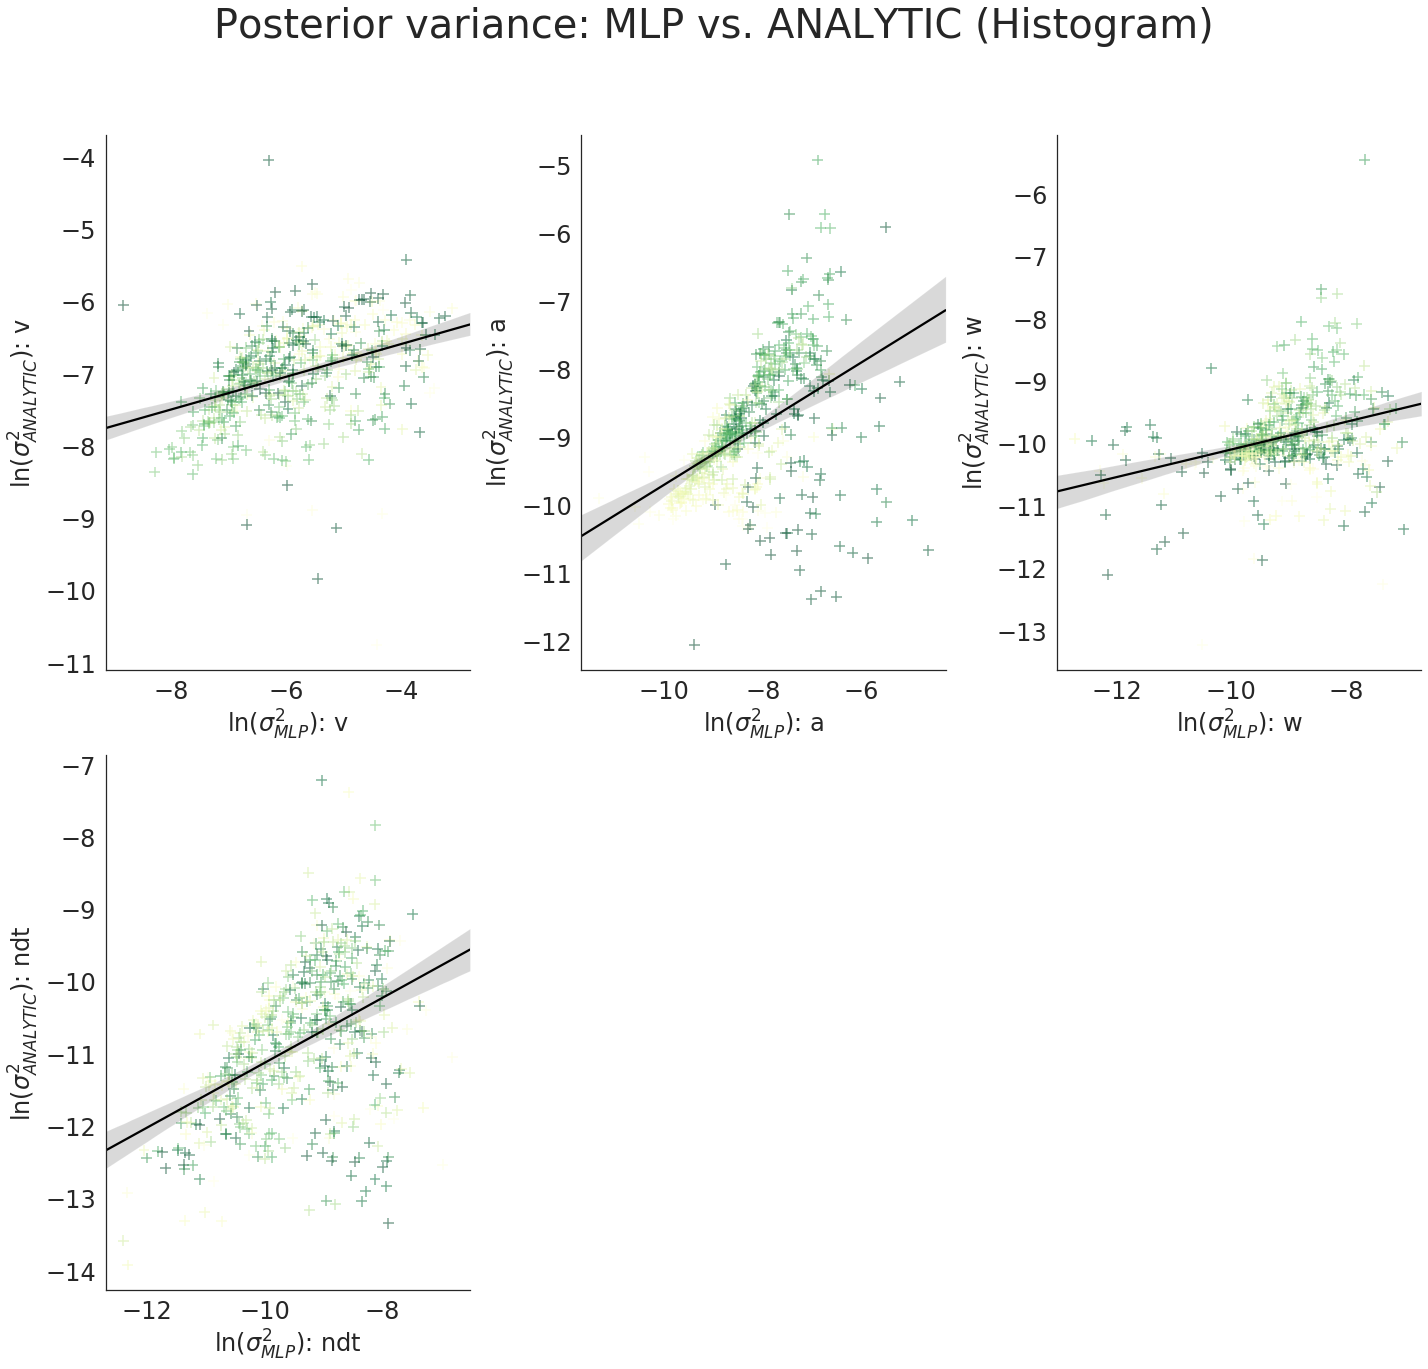

In [796]:
# POSTERIOR VARIANCE REGRESSION: MLP vs. ANALYTIC
posterior_variance_comparison_reg(var_data_1 = mlp_var,
                                  var_data_2 = analytic_var,
                                  params = dat_total[0], # need params here because we used normalize params to color graphs
                                  var_data_1_title = 'MLP',
                                  var_data_2_title = 'ANALYTIC',
                                  ax_titles = ax_titles_ddm,
                                  cols = 3)

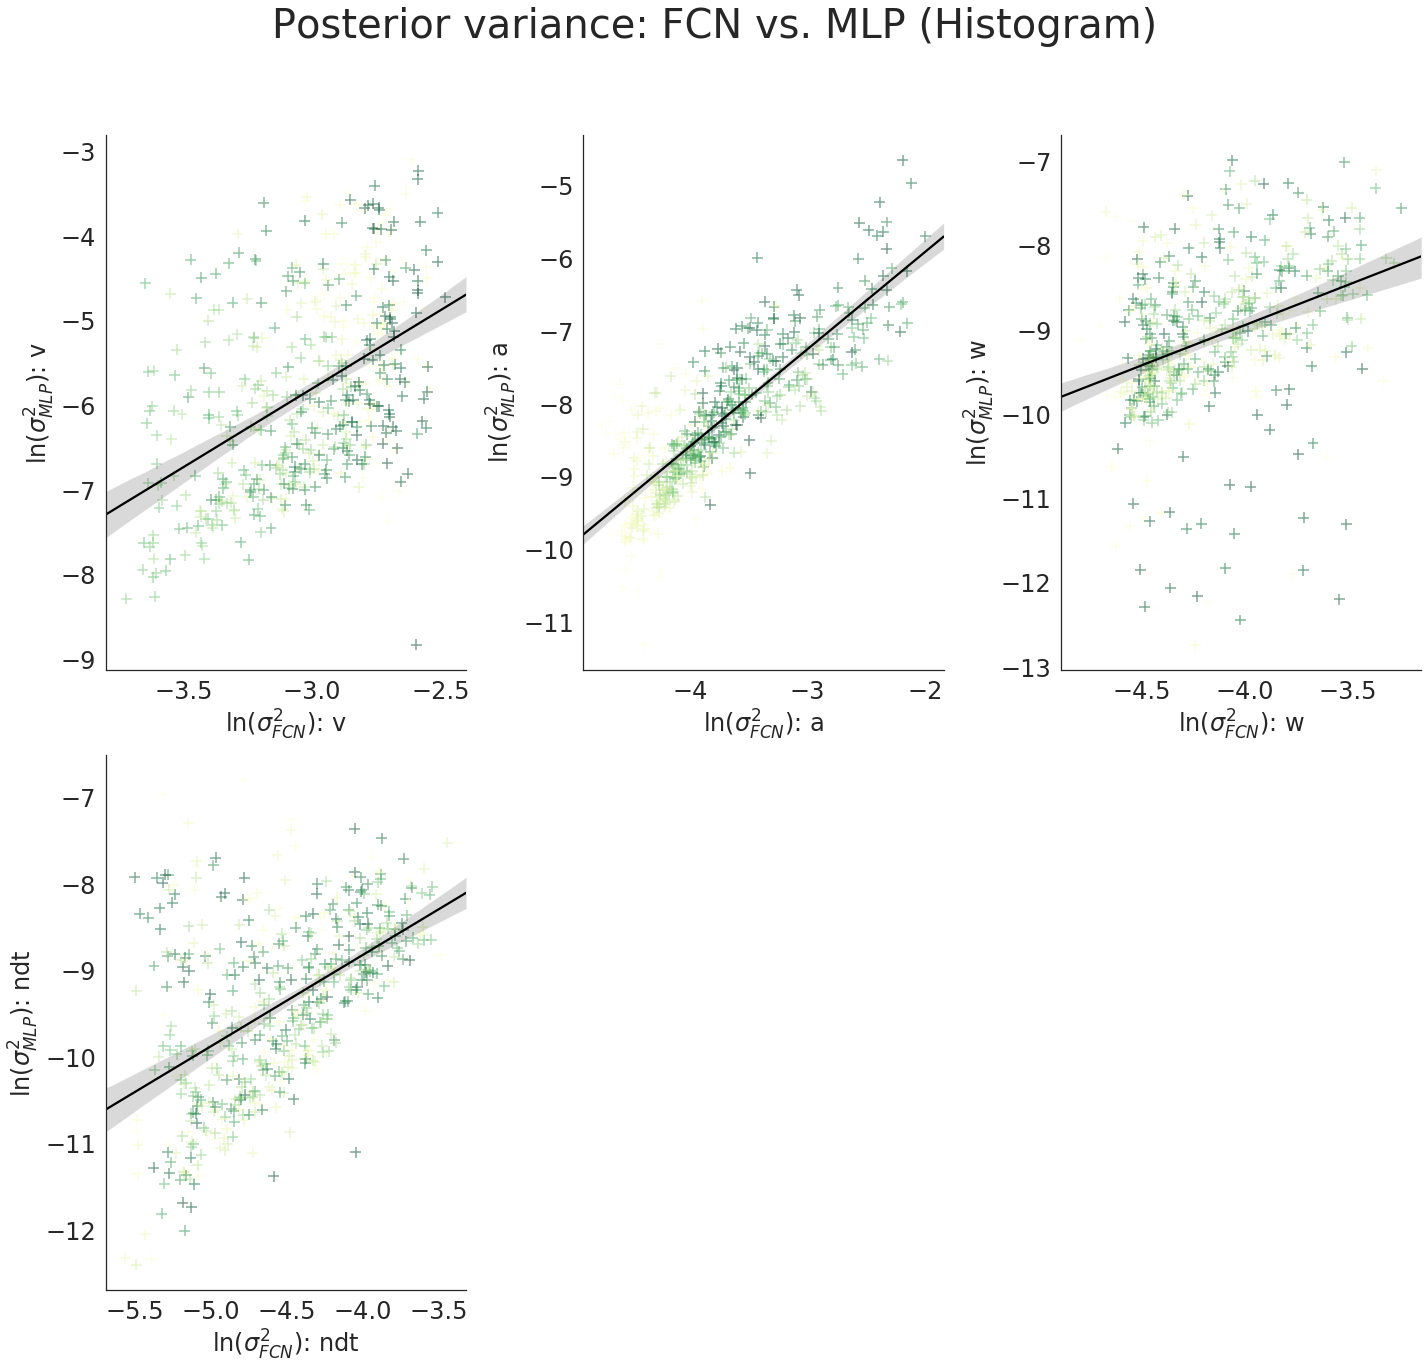

In [797]:
# POSTERIOR VARIANCE REGRESSION: FCN vs. MLP
posterior_variance_comparison_reg(var_data_1 = deep_inference_var,
                                  var_data_2 = mlp_var,
                                  params = dat_total[0], # need params here because we used normalize params to color graphs
                                  var_data_1_title = 'FCN',
                                  var_data_2_title = 'MLP',
                                  ax_titles = ax_titles_ddm,
                                  cols = 3)

In [ ]:
# UNUSED 
# SINGLE PLOTS OF INTEREST
fig, ax = plt.subplots(1, 1, 
                       figsize = (10, 10), 
                       sharex = False, 
                       sharey = False)

grayscale_map = plt.get_cmap('YlGn')

plt.scatter(dat_total[0][:, 5], means[:, 5],
            c = dat_total[0][:, 3],
            cmap = grayscale_map,
            alpha = 1)
ax.set_xlabel(ax_titles[i] + ' - ground truth', 
                                    fontsize = 24);
ax.set_ylabel(ax_titles[i] + ' - posterior mean', 
                                fontsize = 24);

cbar = plt.colorbar()
cbar.set_label(ax_titles[3], size = 24)
plt.show()

In [16]:
# BG Data Weibull
fold = '/media/data_cifs/afengler/data/kde/weibull_cdf/method_comparison/'
files_ = os.listdir(fold)
data_weibull = []
meta_weibull = pickle.load(open('/media/data_cifs/afengler/data/real/bg_stn_sampling_ready.pickle', 'rb'))
for file_ in files_:
    if "bg_stn_" in file_:
        print(file_)
        data_weibull.append(pickle.load(open(fold + file_, 'rb'))[2])
        
data_weibull_new = np.zeros((6, 25, 10000, 6))
for i in range(data_weibull_new.shape[1]):
    data_weibull_new[:, i, :, :] = data_weibull[i]
means_weibull = np.mean(data_weibull_new[:, :, 5000:, :], axis = 2)


# BG Data Angle
fold = '/media/data_cifs/afengler/data/kde/angle/method_comparison/'
files_ = os.listdir(fold)
data_angle = []
meta_angle = pickle.load(open('/media/data_cifs/afengler/data/real/bg_stn_sampling_ready.pickle', 'rb'))
for file_ in files_:
    if "bg_stn" in file_:
        print(file_)
        data_angle.append(pickle.load(open(fold + file_, 'rb'))[2])
        
data_angle_new = np.zeros((6, 25, 10000, 5))
for i in range(data_angle_new.shape[1]):
    data_angle_new[:, i, :, :] = data_angle[i]
means_angle = np.mean(data_angle_new[:, :, 5000:, :], axis = 2)

bg_stn_posterior_samples_10.pickle
bg_stn_posterior_samples_9.pickle
bg_stn_posterior_samples_6.pickle
bg_stn_posterior_samples_13.pickle
bg_stn_posterior_samples_14.pickle
bg_stn_posterior_samples_16.pickle
bg_stn_posterior_samples_12.pickle
bg_stn_posterior_samples_23.pickle
bg_stn_posterior_samples_3.pickle
bg_stn_posterior_samples_8.pickle
bg_stn_posterior_samples_17.pickle
bg_stn_posterior_samples_19.pickle
bg_stn_posterior_samples_18.pickle
bg_stn_posterior_samples_22.pickle
bg_stn_posterior_samples_15.pickle
bg_stn_posterior_samples_7.pickle
bg_stn_posterior_samples_24.pickle
bg_stn_posterior_samples_5.pickle
bg_stn_posterior_samples_1.pickle
bg_stn_posterior_samples_11.pickle
bg_stn_posterior_samples_4.pickle
bg_stn_posterior_samples_20.pickle
bg_stn_posterior_samples_2.pickle
bg_stn_posterior_samples_25.pickle
bg_stn_posterior_samples_21.pickle
bg_stn_posterior_samples_10.pickle
bg_stn_posterior_samples_9.pickle
bg_stn_posterior_samples_6.pickle
bg_stn_posterior_samples_13.pic

In [3]:
# SUPPORT FUNCTIONS GRAPHS
def bgn_posterior_plot(ax_titles = ['v', 'a', 'w', 'ndt', 'alpha', 'beta'], 
                            title = 'BG-STN: PARAMETER RECOVERY WEIBULL',
                            x_labels = [],
                            data = [],
                            cols = 3):
    
    rows = int(np.ceil(len(ax_titles) / cols))

    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)
    fig.suptitle(title, fontsize = 40)

    sns.despine(right = True)

    for i in range(data.shape[2]):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        sns.set(style="whitegrid")
        sns.violinplot(data = data[:, :, i].T,
                       ax = ax[row_tmp, col_tmp])
#         ax[row_tmp, col_tmp].set_xlabel(ax_titles[i] + ' - ground truth', 
#                                         fontsize = 24);
        ax[row_tmp, col_tmp].set_ylabel(ax_titles[i] + ' - posterior mean', 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].tick_params(axis = "x", 
                                         labelsize = 24)
        ax[row_tmp, col_tmp].set_xticklabels(x_labels, size = 14)
        #ax[row_tmp, col_tmp].set_yticklabels(size = 20)
    for i in range(data.shape[1], rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    #plt.setp(ax, yticks = [])
    return plt.show()

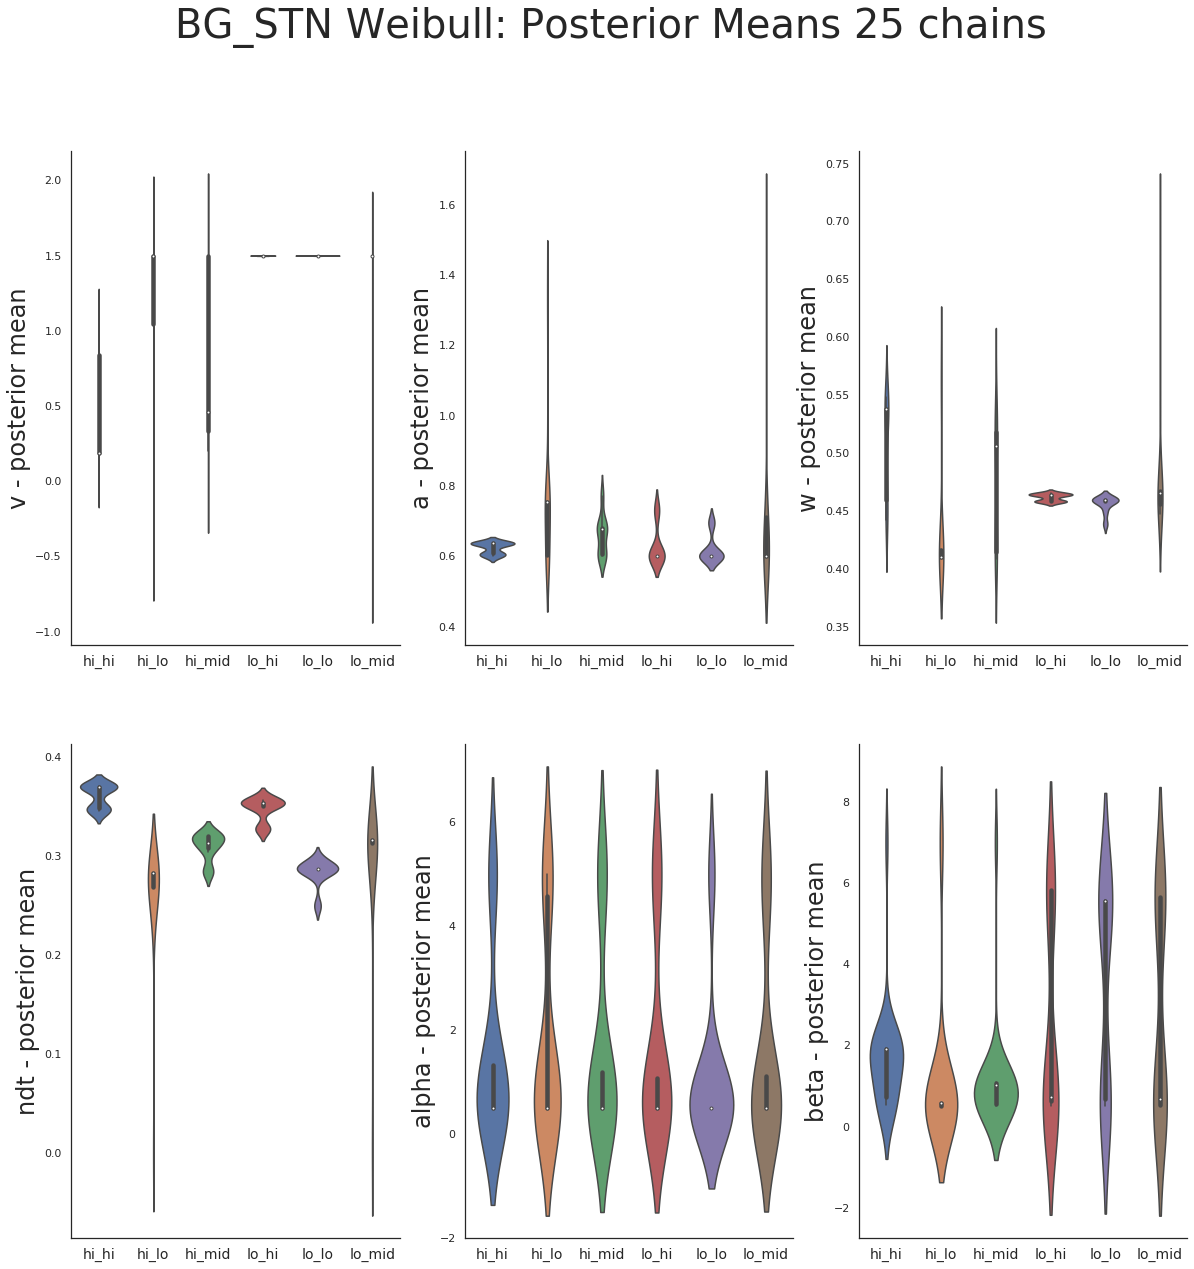

In [237]:
x_labels = ['hi_hi', 'hi_lo', 'hi_mid', 'lo_hi', 'lo_lo', 'lo_mid']
bgn_posterior_plot(title = 'BG_STN Weibull: Posterior Means 25 chains',
                   ax_titles = ['v', 'a', 'w', 'ndt', 'alpha', 'beta'], 
                   data = means_weibull,
                   x_labels = x_labels)

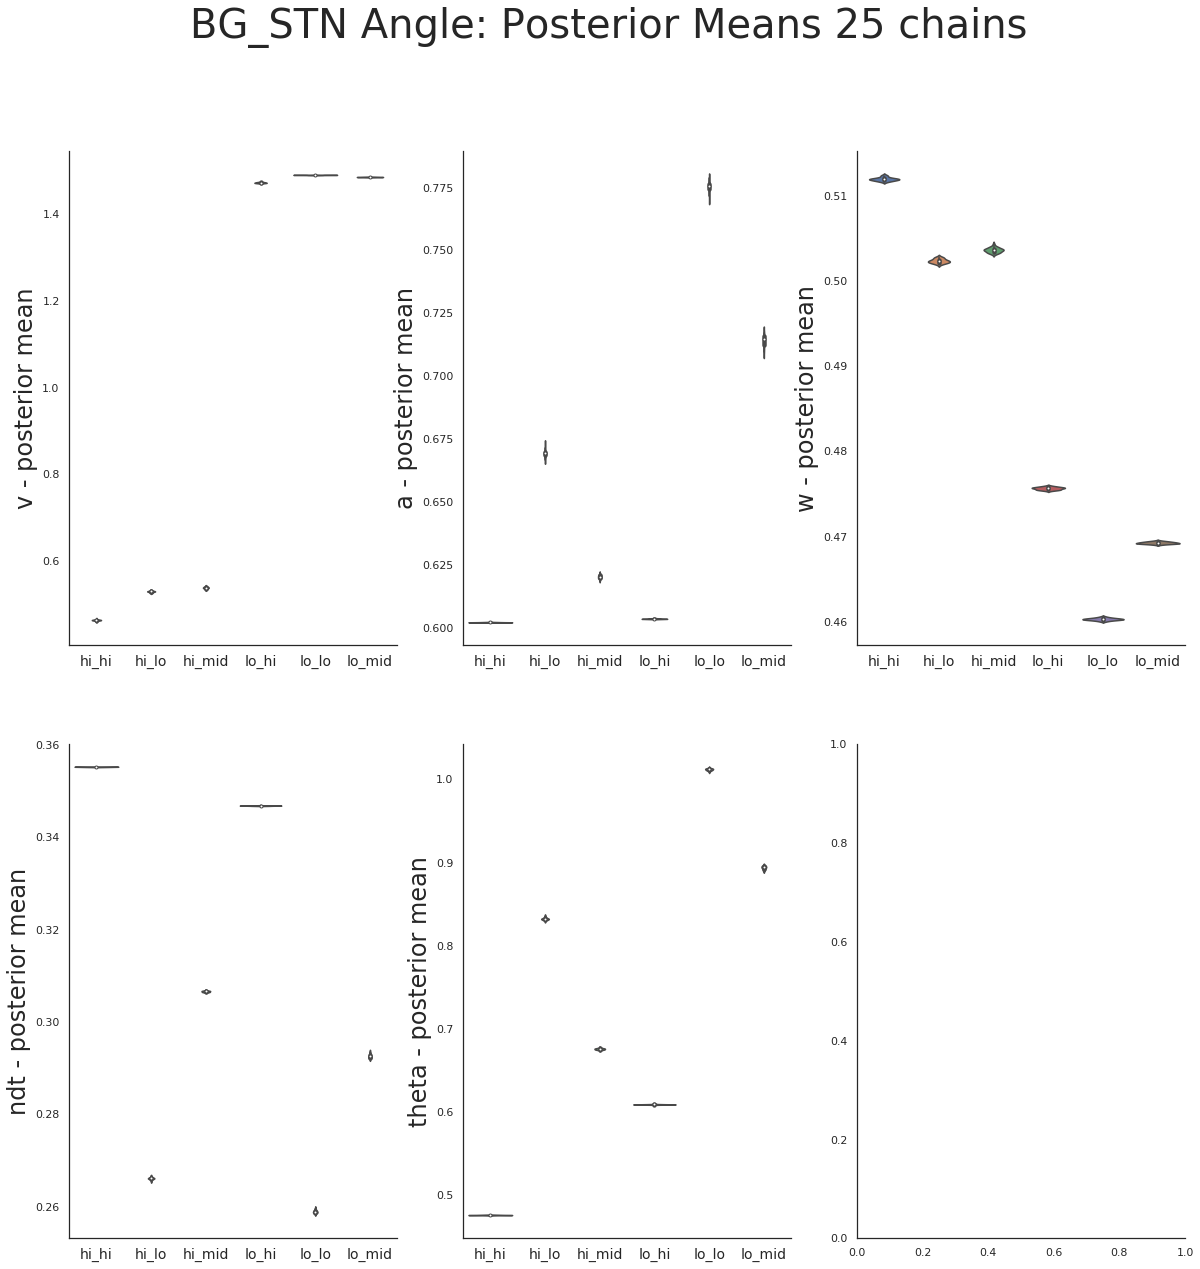

In [238]:
x_labels = ['hi_hi', 'hi_lo', 'hi_mid', 'lo_hi', 'lo_lo', 'lo_mid']
bgn_posterior_plot(title = 'BG_STN Angle: Posterior Means 25 chains',
                   ax_titles = ['v', 'a', 'w', 'ndt', 'theta'], 
                   data = means_angle,
                   x_labels = x_labels)

In [52]:
# A of T plot
def compute_boundary_rmse(mode = 'max_t_global', # max_t_global, max_t_local, quantile
                          boundary_fun = bf.weibull_cdf, # bf.angle etc.
                          parameters_estimated = [],
                          parameters_true = [],
                          max_t = 20,
                          n_probes = 1000):
    
    parameters_estimated_tup = tuple(map(tuple, parameters_estimated))
    parameters_true_tup = tuple(map(tuple, parameters_true))
    t_probes = np.linspace(0, max_t, n_probes)
    bnd_est = np.zeros((len(parameters_estimated), n_probes))
    bnd_true = np.zeros((len(parameters_estimated), n_probes))
    
    # get bound estimates
    for i in range(len(parameters_estimated)):
        #print(parameters_estimated[i])
        bnd_est[i] = np.maximum(boundary_fun(*(t_probes, ) + parameters_estimated_tup[i]), 0)
        bnd_true[i] = np.maximum(boundary_fun(*(t_probes, ) + parameters_true_tup[i]), 0)
        #bnd_est[i] = np.maximum(boundary_fun(parameters_estimated[i], t = t_probes), 0)
        #bnd_true[i] = np.maximum(boundary_fun(parameters_true[i], t = t_probes), 0)
        if i % 100 == 0:
            print(i)
    # compute rmse
    rmse_vec = np.zeros((len(parameters_estimated_tup)))
    dist_param_euclid = np.zeros((len(parameters_estimated_tup)))
    for i in range(len(parameters_estimated)):
        rmse_vec[i] = np.sqrt(np.sum(np.square(bnd_est[i] - bnd_true[i])) / n_probes)
        dist_param_euclid[i] = np.sqrt(np.sum(np.square(parameters_estimated[i] - parameters_true[i])))
    
        
    return rmse_vec, dist_param_euclid

In [53]:
rmse, dist_param_euclid = compute_boundary_rmse(mode = 'max_t_global',
                                                boundary_fun = bf.weibull_cdf,
                                                parameters_estimated = means[:, 4:],
                                                parameters_true = dat_total[0][:, 4:],
                                                max_t = 20,
                                                n_probes = 1000)

0
100
200
300
400
500
600
700
800
900


In [54]:
dat_total[1].shape

(1000, 10000, 6)

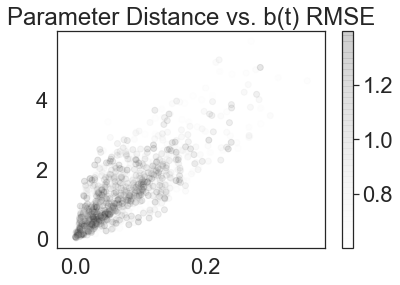

In [55]:
plt.scatter(rmse, dist_param_euclid, 
            c = dat_total[0][:,1],
            cmap = 'Greys', 
            alpha = 0.1)
plt.title('Parameter Distance vs. b(t) RMSE')
plt.colorbar()
plt.show()

In [18]:
dat_total[0][:, 1].shape

(1000,)

In [56]:
sorted_idx = np.argsort(rmse)
bottom_idx = sorted_idx[:10]
middle_idx = sorted_idx[int(sorted_idx.shape[0] / 2) - 5: int(sorted_idx.shape[0] / 2) + 5]
top_idx = sorted_idx[-10:]

In [58]:
def bgn_posterior_predictive_plot(ax_titles = [], 
                                 title = 'BG-STN: POSTERIOR PREDICTIVE',
                                 x_labels = [],
                                 posterior_parameters = [],
                                 data = [],
                                 cols = 3,
                                 model = 'angle',
                                 figure_name = 'Posterior Predictives',
                                 n_post_params = 200,
                                 samples_by_param = 10,
                                 save = False,
                                 show = True):
    
    rows = int(np.ceil(len(ax_titles) / cols))
    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True,
            font_scale = 2)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)
    fig.suptitle(title, fontsize = 40)
    sns.despine(right = True)

    for i in range(len(ax_titles)):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        
        tmp = np.zeros((n_post_params*samples_by_param, 2))
        idx = np.random.choice(posterior_parameters.shape[1], size = n_post_params, replace = False)

        # Run Model simulations for posterior samples
        for j in range(n_post_params):
            if model == 'angle':
                out = cds.ddm_flexbound(v = posterior_parameters[i, idx[j], 0],
                                        a = posterior_parameters[i, idx[j], 1],
                                        w = posterior_parameters[i, idx[j], 2],
                                        ndt = posterior_parameters[i, idx[j], 3],
                                        s = 1,
                                        delta_t = 0.01, 
                                        max_t = 20,
                                        n_samples = samples_by_param,
                                        print_info = False,
                                        boundary_fun = bf.angle,
                                        boundary_multiplicative = False,
                                        boundary_params = {'theta': posterior_parameters[i, idx[j], 4]})
            
            if model == 'weibull_cdf':
                out = cds.ddm_flexbound(v = posterior_parameters[i, idx[j], 0],
                                        a = posterior_parameters[i, idx[j], 1],
                                        w = posterior_parameters[i, idx[j], 2],
                                        ndt = posterior_parameters[i, idx[j], 3],
                                        s = 1,
                                        delta_t = 0.01, 
                                        max_t = 20,
                                        n_samples = samples_by_param,
                                        print_info = False,
                                        boundary_fun = bf.weibull_cdf,
                                        boundary_multiplicative = True,
                                        boundary_params = {'alpha': posterior_parameters[i, idx[j], 4],
                                                           'beta': posterior_parameters[i, idx[j], 5]})
            
            tmp[(10 * j):(10 * (j + 1)), :] = np.concatenate([out[0], out[1]], axis = 1)
        
        # Run Model simulations for true parameters
        if model == 'angle':
            out = cds.ddm_flexbound(v = data[i, 0],
                                    a = data[i, 1],
                                    w = data[i, 2],
                                    ndt = data[i, 3],
                                    s = 1,
                                    delta_t = 0.01, 
                                    max_t = 20,
                                    n_samples = 10000,
                                    print_info = False,
                                    boundary_fun = bf.angle,
                                    boundary_multiplicative = False,
                                    boundary_params = {'theta': data[i, 4]})
            
        if model == 'weibull_cdf':
            out = cds.ddm_flexbound(v = data[i, 0],
                                    a = data[i, 1],
                                    w = data[i, 2],
                                    ndt = data[i, 3],
                                    s = 1,
                                    delta_t = 0.01, 
                                    max_t = 20,
                                    n_samples = 10000,
                                    print_info = False,
                                    boundary_fun = bf.weibull_cdf,
                                    boundary_multiplicative = True,
                                    boundary_params = {'alpha': data[i, 4],
                                                       'beta': data[i, 5]})
        dat_tmp = np.concatenate([out[0], out[1]], axis = 1)
        print('passed through')
            
        sns.distplot(tmp[:, 0] * tmp[:, 1], 
                     bins = 50, 
                     kde = False, 
                     rug = False, 
                     hist_kws = {'alpha': 0.2, 'color': 'blue', 'density': 1},
                     ax = ax[row_tmp, col_tmp]);
        sns.distplot(dat_tmp[:, 0] * dat_tmp[:, 1], 
                     hist_kws = {'alpha': 0.2, 'color': 'green', 'density': 1}, 
                     bins = 50, 
                     kde = False, 
                     rug = False,
                     ax = ax[row_tmp, col_tmp])
        
        ax[row_tmp, col_tmp].legend(labels = [model, 'posterior'], fontsize = 20)
        ax[row_tmp, col_tmp].set_xlabel('rt', 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].set_ylabel('density', 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].set_title(ax_titles[i],
                                       fontsize = 24)
        ax[row_tmp, col_tmp].tick_params(axis = 'y', size = 24)
        ax[row_tmp, col_tmp].tick_params(axis = 'x', size = 24)
        
    for i in range(len(ax_titles), rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    #plt.setp(ax, yticks = [])
    if save == True:
        plt.savefig(os.getcwd() + '/figures/' + figure_name + model, dpi = 150)
    
    if show:
        return plt.show()

passed through
passed through
passed through
passed through
passed through
passed through
passed through
passed through
passed through


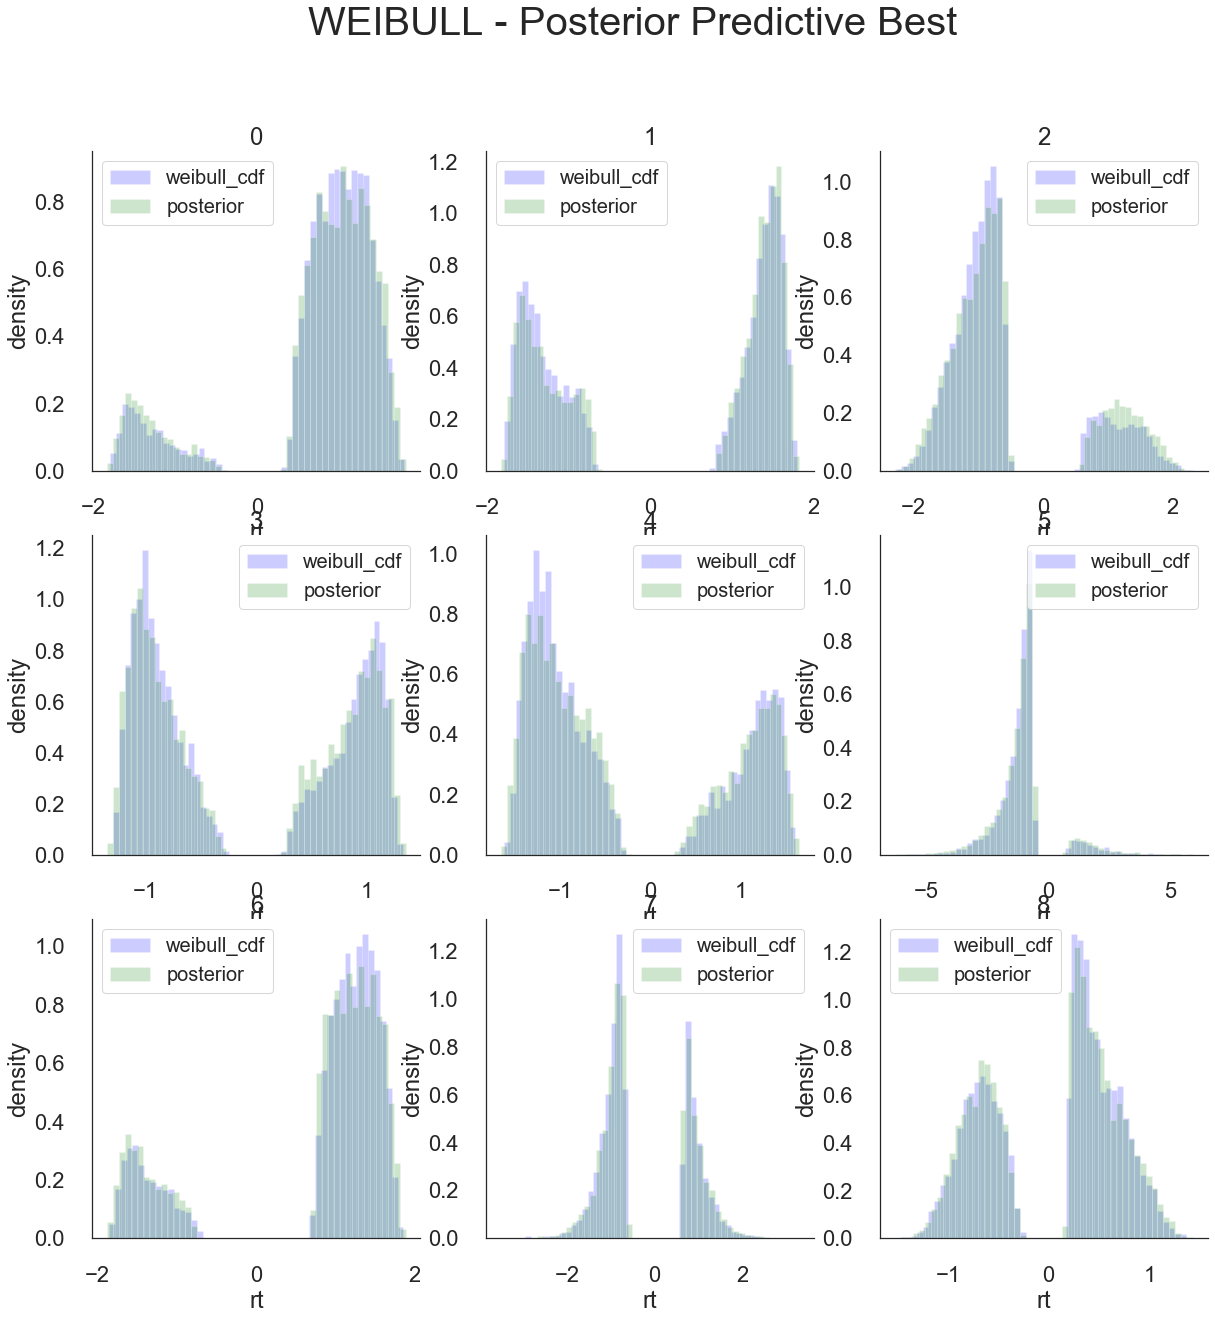

In [67]:
# Best
bgn_posterior_predictive_plot(ax_titles =[str(i) for i in range(9)],
                              title = 'WEIBULL - Posterior Predictive Best',
                              posterior_parameters = dat_total[1][bottom_idx, 5000:, :],
                              data = dat_total[0][bottom_idx, :],
                              cols = 3,
                              model = 'weibull_cdf',
                              figure_name = 'bg_posterior_predictive',
                              n_post_params = 500,
                              samples_by_param = 10,
                              show = True)

passed through
passed through
passed through
passed through
passed through
passed through
passed through
passed through
passed through


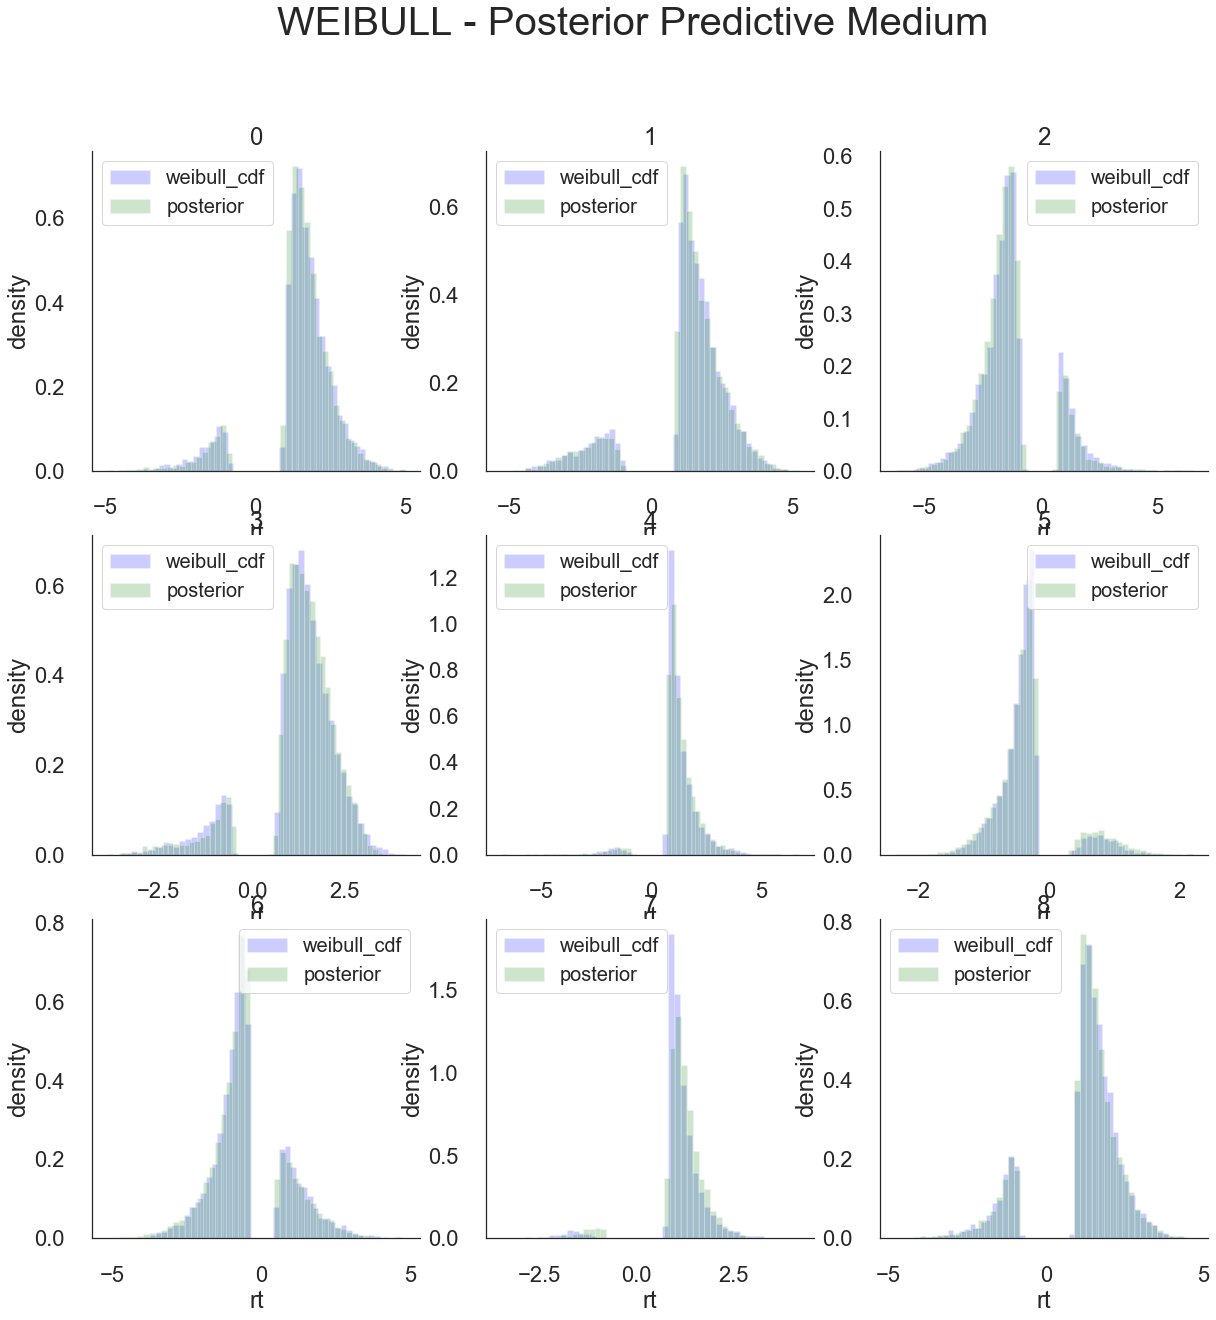

In [68]:
# Middle
bgn_posterior_predictive_plot(ax_titles =[str(i) for i in range(9)],
                              title = 'WEIBULL - Posterior Predictive Medium',
                              posterior_parameters = dat_total[1][middle_idx, 5000:, :],
                              data = dat_total[0][middle_idx, :],
                              cols = 3,
                              model = 'weibull_cdf',
                              figure_name = 'bg_posterior_predictive',
                              n_post_params = 500,
                              samples_by_param = 10,
                              show = True)

passed through
passed through
passed through
passed through
passed through
passed through
passed through
passed through
passed through


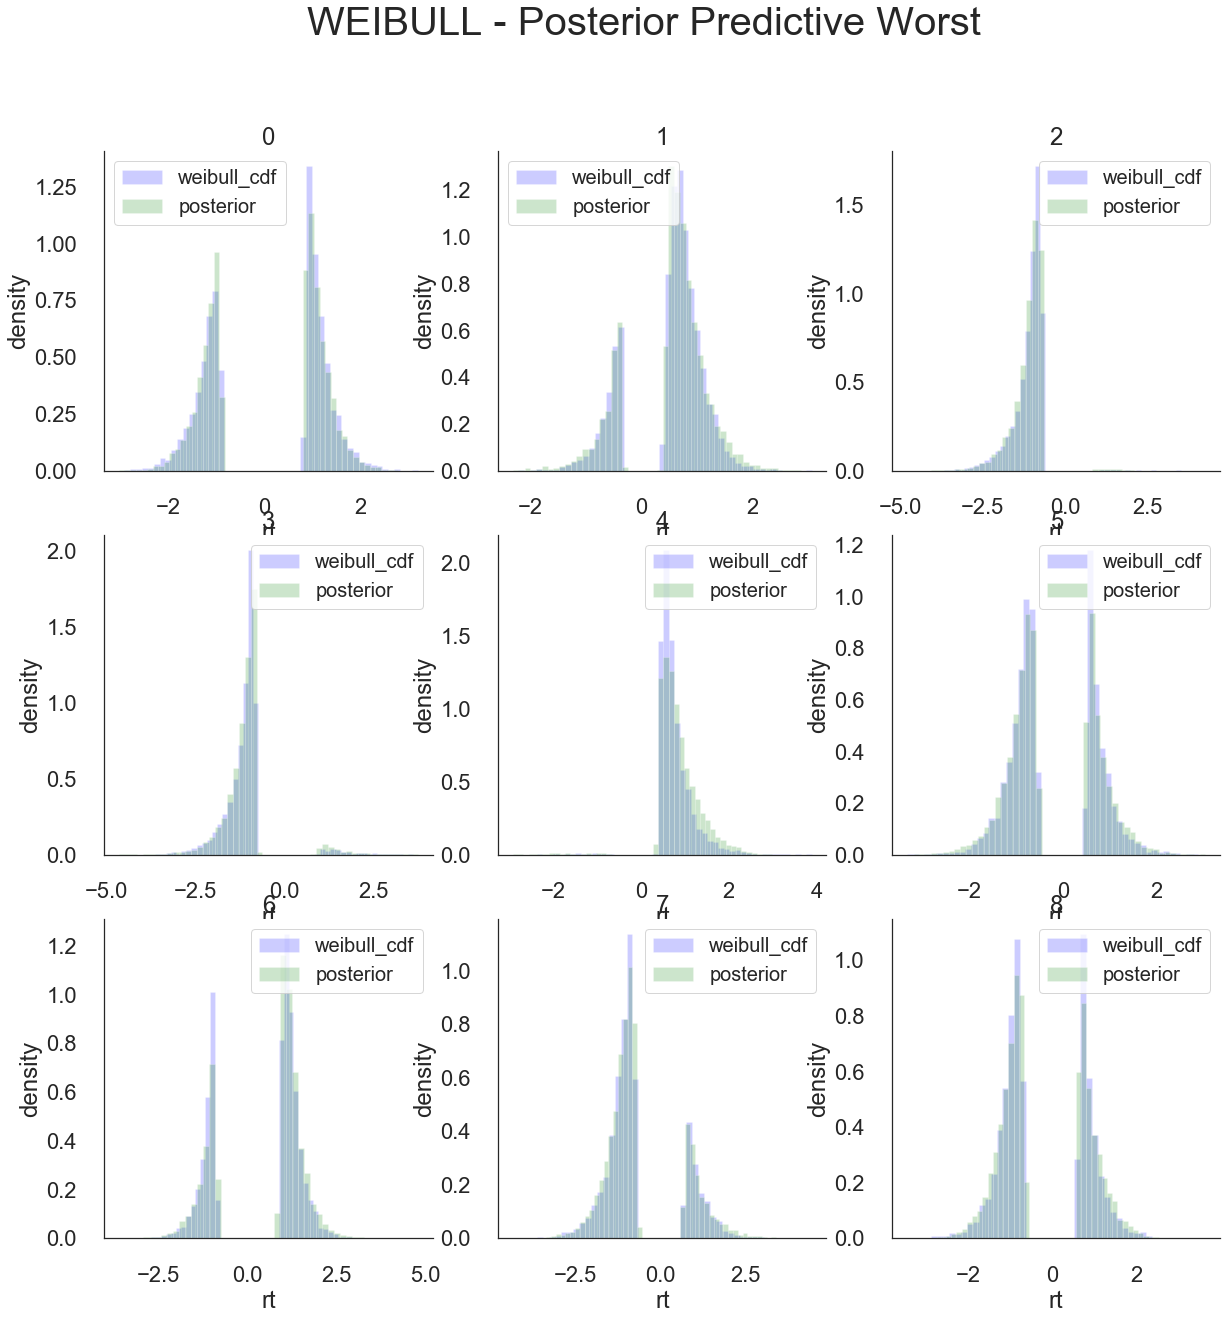

In [69]:
# Worst
bgn_posterior_predictive_plot(ax_titles =[str(i) for i in range(9)],
                              title = 'WEIBULL - Posterior Predictive Worst',
                              posterior_parameters = dat_total[1][top_idx, 5000:, :],
                              data = dat_total[0][top_idx, :],
                              cols = 3,
                              model = 'weibull_cdf',
                              figure_name = 'bg_posterior_predictive',
                              n_post_params = 500,
                              samples_by_param = 10,
                              show = True)

In [63]:
# Plot bound
# Mean posterior predictives
def boundary_posterior_plot(ax_titles = ['hi-hi', 'hi-lo', 'hi-mid', 'lo-hi', 'lo-mid'], 
                            title = 'BG-STN: Bound Posterior',
                            posterior_parameters = [],
                            data = [],
                            cols = 3,
                            model = 'weibull_cdf',
                            figure_name = 'bg_posterior_bounds',
                            n_post_params = 500,
                            samples_by_param = 10,
                            max_t = 2,
                            show = True,
                            save = False):
    
    rows = int(np.ceil(len(ax_titles) / cols))
    sub_idx = np.random.choice(posterior_parameters.shape[1], size = n_post_params)
    posterior_parameters = posterior_parameters[:, sub_idx, :]
    
    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True,
            font_scale = 2)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)
    my_suptitle = fig.suptitle(title + model, fontsize = 40)
    sns.despine(right = True)
    
    t_s = np.arange(0, max_t, 0.01)
    for i in range(len(ax_titles)):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        
        idx = np.random.choice(posterior_parameters.shape[1], size = n_post_params, replace = False)

        ax[row_tmp, col_tmp].set_xlim(0, max_t)
        ax[row_tmp, col_tmp].set_ylim(-2, 2)
        # Run simulations and add histograms
        # True params
        if model == 'angle':
            out = cds.ddm_flexbound(v = data[i, 0],
                                    a = data[i, 1],
                                    w = data[i, 2],
                                    ndt = data[i, 3],
                                    s = 1,
                                    delta_t = 0.01, 
                                    max_t = 20,
                                    n_samples = 10000,
                                    print_info = False,
                                    boundary_fun = bf.angle,
                                    boundary_multiplicative = False,
                                    boundary_params = {'theta': data[i, 4]})
            
        if model == 'weibull_cdf':
            out = cds.ddm_flexbound(v = data[i, 0],
                                    a = data[i, 1],
                                    w = data[i, 2],
                                    ndt = data[i, 3],
                                    s = 1,
                                    delta_t = 0.01, 
                                    max_t = 20,
                                    n_samples = 10000,
                                    print_info = False,
                                    boundary_fun = bf.weibull_cdf,
                                    boundary_multiplicative = True,
                                    boundary_params = {'alpha': data[i, 4],
                                                       'beta': data[i, 5]})
        tmp_true = np.concatenate([out[0], out[1]], axis = 1)
        choice_p_up_true = np.sum(tmp_true[:, 1] == 1) / tmp_true.shape[0]
        
        # Run Model simulations for posterior samples
        tmp_post = np.zeros((n_post_params*samples_by_param, 2))
        for j in range(n_post_params):
            if model == 'angle':
                out = cds.ddm_flexbound(v = posterior_parameters[i, idx[j], 0],
                                        a = posterior_parameters[i, idx[j], 1],
                                        w = posterior_parameters[i, idx[j], 2],
                                        ndt = posterior_parameters[i, idx[j], 3],
                                        s = 1,
                                        delta_t = 0.01, 
                                        max_t = 20,
                                        n_samples = samples_by_param,
                                        print_info = False,
                                        boundary_fun = bf.angle,
                                        boundary_multiplicative = False,
                                        boundary_params = {'theta': posterior_parameters[i, idx[j], 4]})
            
            if model == 'weibull_cdf':
                out = cds.ddm_flexbound(v = posterior_parameters[i, idx[j], 0],
                                        a = posterior_parameters[i, idx[j], 1],
                                        w = posterior_parameters[i, idx[j], 2],
                                        ndt = posterior_parameters[i, idx[j], 3],
                                        s = 1,
                                        delta_t = 0.01, 
                                        max_t = 20,
                                        n_samples = samples_by_param,
                                        print_info = False,
                                        boundary_fun = bf.weibull_cdf,
                                        boundary_multiplicative = True,
                                        boundary_params = {'alpha': posterior_parameters[i, idx[j], 4],
                                                           'beta': posterior_parameters[i, idx[j], 5]})
            
            tmp_post[(10 * j):(10 * (j + 1)), :] = np.concatenate([out[0], out[1]], axis = 1)
        
        choice_p_up_post = np.sum(tmp_post[:, 1] == 1) / tmp_post.shape[0]
        
        #ax.set_ylim(-4, 2)
        ax_tmp = ax[row_tmp, col_tmp].twinx()
        ax_tmp.set_ylim(-2, 2)
        ax_tmp.set_yticks([])
        
        
        counts, bins = np.histogram(tmp_post[tmp_post[:, 1] == 1, 0],
                                bins = np.linspace(0, 10, 100))
    
        counts_2, bins = np.histogram(tmp_post[tmp_post[:, 1] == 1, 0],
                                      bins = np.linspace(0, 10, 100),
                                      density = True)
        ax_tmp.hist(bins[:-1], 
                    bins, 
                    weights = choice_p_up_post * counts_2,
                    alpha = 0.2, 
                    color = 'black',
                    edgecolor = 'none',
                    zorder = -1)
        
        counts, bins = np.histogram(tmp_true[tmp_true[:, 1] == 1, 0],
                                bins = np.linspace(0, 10, 100))
    
        counts_2, bins = np.histogram(tmp_true[tmp_true[:, 1] == 1, 0],
                                      bins = np.linspace(0, 10, 100),
                                      density = True)
        ax_tmp.hist(bins[:-1], 
                    bins, 
                    weights = choice_p_up_true * counts_2,
                    alpha = 0.2, 
                    color = 'red',
                    edgecolor = 'none',
                    zorder = -1)
        
        
        
#         ax_tmp.hist(tmp_true[tmp_true[:, 1] == 1, 0], 
#                     bins = np.linspace(0, 10, 100), 
#                     density = True, alpha = 0.2,
#                     color = 'red',
#                     edgecolor='none',
#                     zorder = -1)
#         ax_tmp.hist(tmp_post[tmp_post[:, 1] == 1, 0],
#                     bins = np.linspace(0, 10, 100),
#                     density = True,
#                     alpha = 0.2,
#                     color = 'black',
#                     edgecolor='none',
#                     zorder = -1)
        
        #ax.invert_xaxis()
        ax_tmp = ax[row_tmp, col_tmp].twinx()
        ax_tmp.set_ylim(2, -2)
        ax_tmp.set_yticks([])
        
        counts, bins = np.histogram(tmp_post[tmp_post[:, 1] == -1, 0],
                        bins = np.linspace(0, 10, 100))
    
        counts_2, bins = np.histogram(tmp_post[tmp_post[:, 1] == -1, 0],
                                      bins = np.linspace(0, 10, 100),
                                      density = True)
        ax_tmp.hist(bins[:-1], 
                    bins, 
                    weights = (1 - choice_p_up_post) * counts_2,
                    alpha = 0.2, 
                    color = 'black',
                    edgecolor = 'none',
                    zorder = -1)
        
        counts, bins = np.histogram(tmp_true[tmp_true[:, 1] == -1, 0],
                                bins = np.linspace(0, 10, 100))
    
        counts_2, bins = np.histogram(tmp_true[tmp_true[:, 1] == -1, 0],
                                      bins = np.linspace(0, 10, 100),
                                      density = True)
        ax_tmp.hist(bins[:-1], 
                    bins, 
                    weights = (1 - choice_p_up_true) * counts_2,
                    alpha = 0.2, 
                    color = 'red',
                    edgecolor = 'none',
                    zorder = -1)
        
        
#         ax_tmp.hist(tmp_true[tmp_true[:, 1] == -1, 0], 
#                     bins = np.linspace(0, 10, 100), 
#                     density = True, alpha = 0.2,
#                     color = 'red',
#                     edgecolor='none',
#                     zorder = -1)
#         ax_tmp.hist(tmp_post[tmp_post[:, 1] == -1, 0],
#                     bins = np.linspace(0, 10, 100),
#                     density = True,
#                     alpha = 0.2,
#                     color = 'black',
#                     edgecolor='none',
#                     zorder = -1)
        
        # Plot posterior samples 
        for j in range(n_post_params):
            if model == 'weibull_cdf':
                b = posterior_parameters[i, idx[i], 1] * bf.weibull_cdf(t = t_s, 
                                                                        alpha = posterior_parameters[i, idx[j], 4],
                                                                        beta = posterior_parameters[i, idx[j], 5])
            if model == 'angle':
                b = np.maximum(posterior_parameters[i, idx[i], 1] + bf.angle(t = t_s, 
                                                                             theta = posterior_parameters[i, idx[j], 4]), 0)
            
            start_point_tmp = - posterior_parameters[i, idx[j], 1] + \
                              (2 * posterior_parameters[i, idx[j], 1] * posterior_parameters[i, idx[j], 2])
            slope_tmp = posterior_parameters[i, idx[j], 0]
            
            ax[row_tmp, col_tmp].plot(t_s + posterior_parameters[i, idx[j], 3], b, 'black',
                                      t_s + posterior_parameters[i, idx[j], 3], -b, 'black', 
                                      alpha = 0.05,
                                      zorder = 1000)
            
            for m in range(len(t_s)):
                if (start_point_tmp + (slope_tmp * t_s[m])) > b[m] or (start_point_tmp + (slope_tmp * t_s[m])) < -b[m]:
                    maxid = m
                    break
                maxid = m
            
            ax[row_tmp, col_tmp].plot(t_s[:maxid] + posterior_parameters[i, idx[j], 3],
                                      start_point_tmp + slope_tmp * t_s[:maxid], 
                                      'black', 
                                      alpha = 0.05,
                                      zorder = 1000)
            
        # Plot true data  
        if model == 'weibull_cdf':
            b = data[i, 1] * bf.weibull_cdf(t = t_s, 
                                            alpha = data[i, 4],
                                            beta = data[i, 5])
        if model == 'angle':
            b = np.maximum(data[i, 1] + bf.angle(t = t_s, theta = data[i, 4]), 0)

        start_point_tmp = - data[i, 1] + \
                          (2 * data[i, 1] * data[i, 2])
        slope_tmp = data[i, 0]

        ax[row_tmp, col_tmp].plot(t_s + data[i, 3], b, 'red', 
                                  t_s + data[i, 3], -b, 'red', 
                                  alpha = 1,
                                  linewidth = 3,
                                  zorder = 1000)
        
        for m in range(len(t_s)):
            if (start_point_tmp + (slope_tmp * t_s[m])) > b[m] or (start_point_tmp + (slope_tmp * t_s[m])) < -b[m]:
                maxid = m
                break
            maxid = m
        
        print('maxid', maxid)
        ax[row_tmp, col_tmp].plot(t_s[:maxid] + data[i, 3], 
                                  start_point_tmp + slope_tmp * t_s[:maxid], 
                                  'red', 
                                  alpha = 1, 
                                  linewidth = 3, 
                                  zorder = 1000)
        
        ax[row_tmp, col_tmp].set_zorder(ax_tmp.get_zorder() + 1)
        ax[row_tmp, col_tmp].patch.set_visible(False)
        print('passed through')
        
        #ax[row_tmp, col_tmp].legend(labels = [model, 'bg_stn'], fontsize = 20)
        ax[row_tmp, col_tmp].set_xlabel('rt', 
                                        fontsize = 20);
        ax[row_tmp, col_tmp].set_ylabel('', 
                                        fontsize = 20);
        ax[row_tmp, col_tmp].set_title(ax_titles[i],
                                       fontsize = 20)
        ax[row_tmp, col_tmp].tick_params(axis = 'y', size = 20)
        ax[row_tmp, col_tmp].tick_params(axis = 'x', size = 20)
        
    for i in range(len(ax_titles), rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')
    
    plt.tight_layout(rect = [0, 0.03, 1, 0.9])
    if save:
        plt.savefig(os.getcwd() + '/figures/' + figure_name + model,
                    dpi = 150, 
                    transparent = False,
                    bbox_inches = 'tight',
                    bbox_extra_artists = [my_suptitle])
    if show:
        return plt.show()

maxid 103
passed through
maxid 108
passed through
maxid 100
passed through
maxid 117
passed through
maxid 128
passed through
maxid 111
passed through
maxid 87
passed through
maxid 161
passed through
maxid 154
passed through


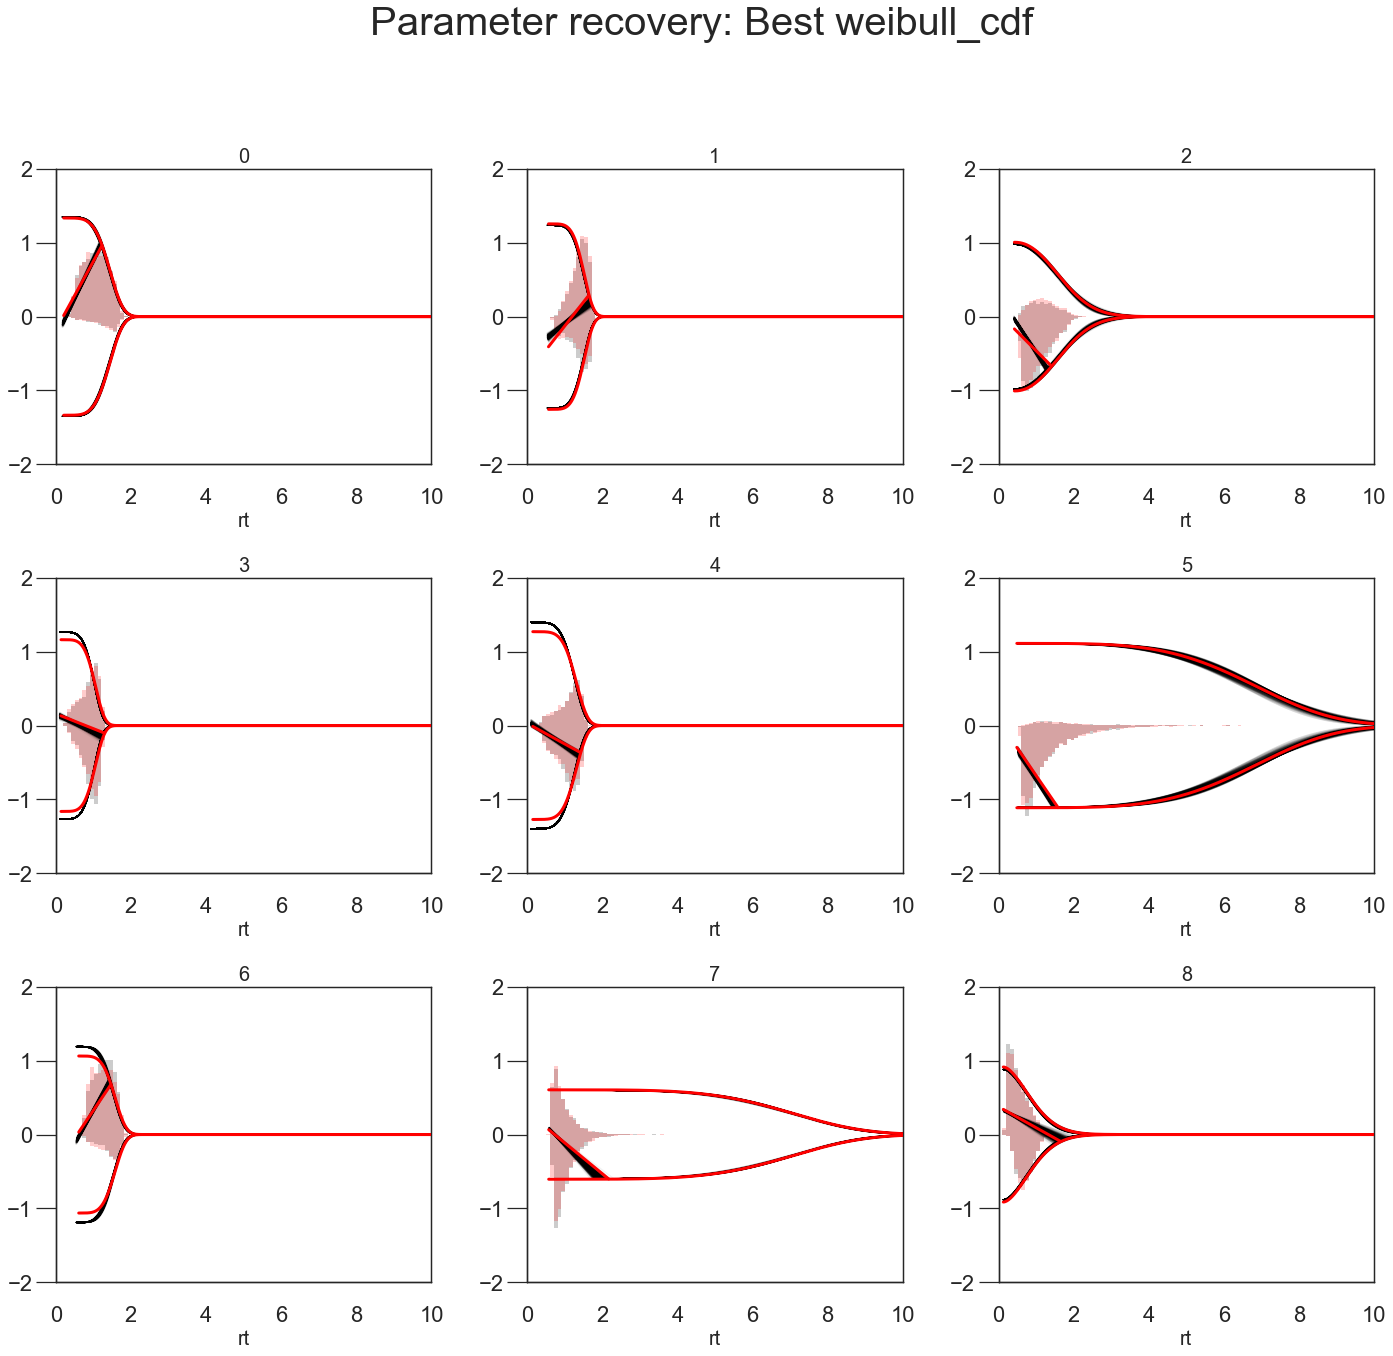

In [64]:
boundary_posterior_plot(ax_titles = [str(i) for i in range(9)], 
                        title = 'Parameter recovery: Best ',
                        posterior_parameters = dat_total[1][bottom_idx, 5000:, :],
                        data = dat_total[0][bottom_idx, :],
                        cols = 3,
                        model = 'weibull_cdf',
                        figure_name = 'bg_posterior_bounds',
                        n_post_params = 500,
                        samples_by_param = 10,
                        max_t = 10,
                        show = True,
                        save = False)

maxid 126
passed through
maxid 151
passed through
maxid 160
passed through
maxid 142
passed through
maxid 85
passed through
maxid 52
passed through
maxid 202
passed through
maxid 73
passed through
maxid 122
passed through


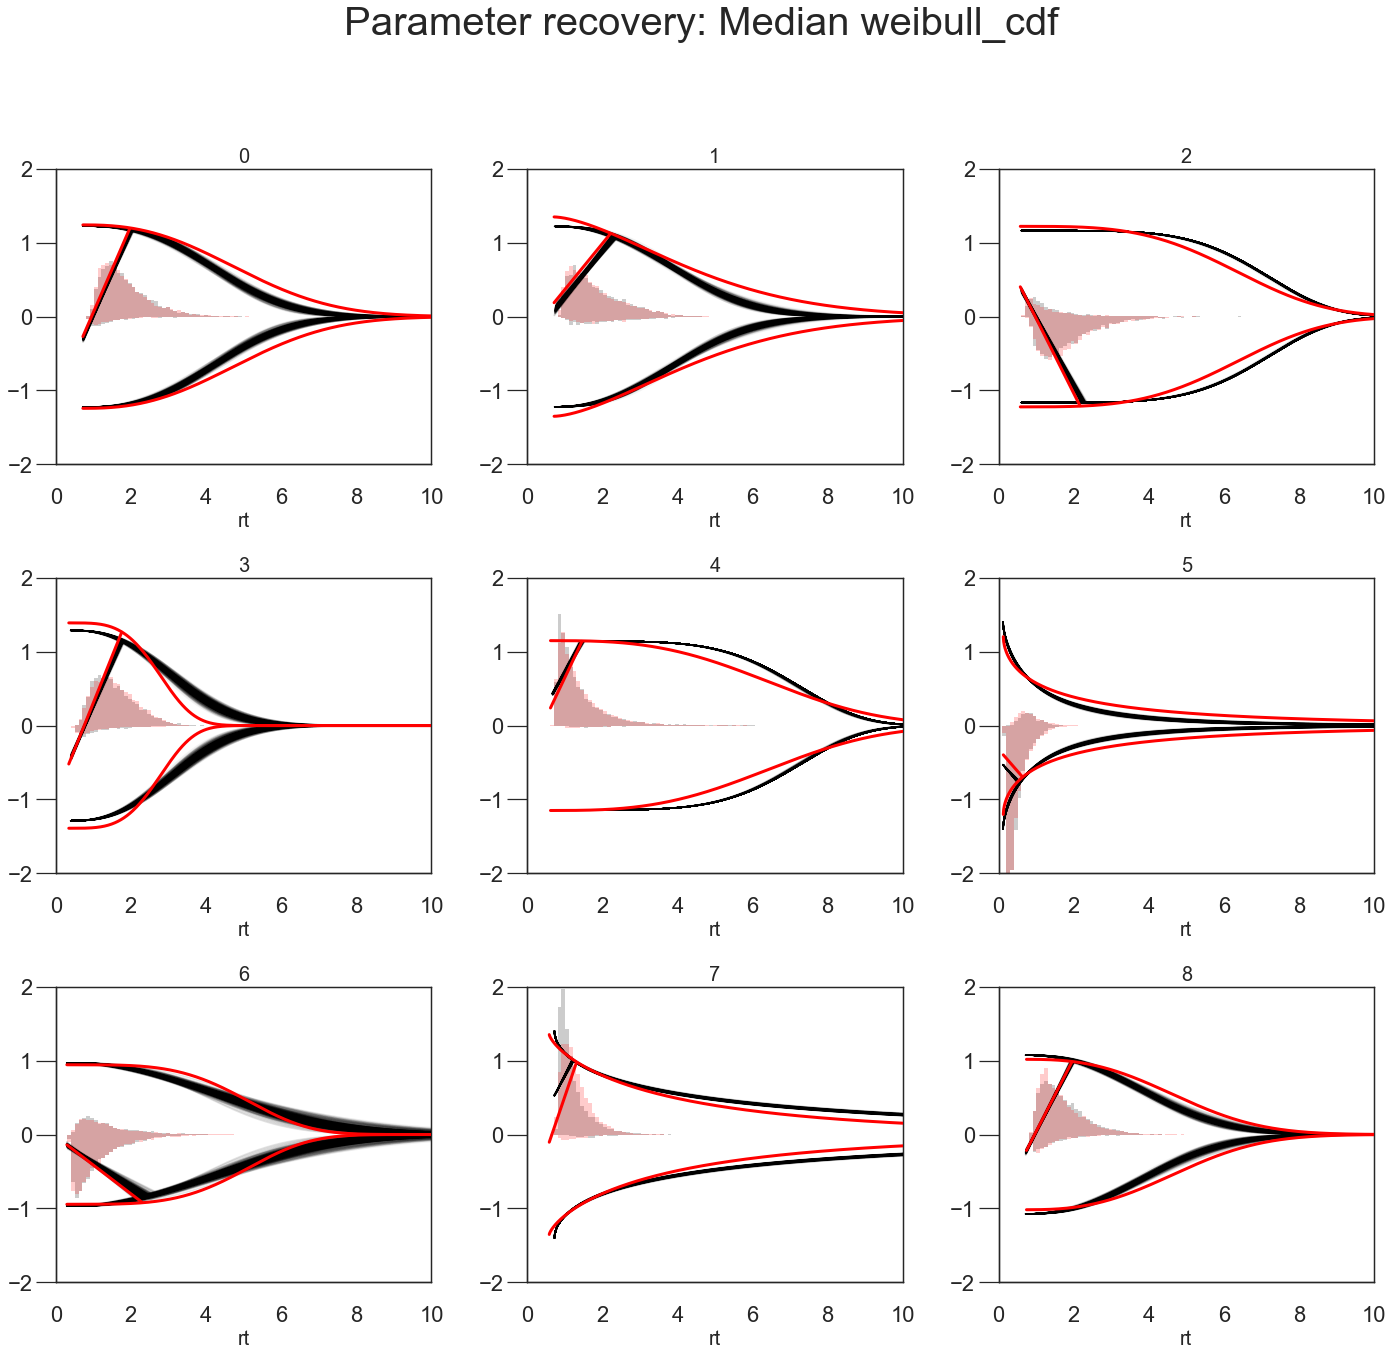

In [65]:
boundary_posterior_plot(ax_titles = [str(i) for i in range(9)], 
                        title = 'Parameter recovery: Median ',
                        posterior_parameters = dat_total[1][middle_idx, 5000:, :],
                        data = dat_total[0][middle_idx, :],
                        cols = 3,
                        model = 'weibull_cdf',
                        figure_name = 'bg_posterior_bounds',
                        n_post_params = 500,
                        max_t = 10,
                        show = True,
                        save = False)

maxid 895
passed through
maxid 74
passed through
maxid 55
passed through
maxid 56
passed through
maxid 63
passed through
maxid 132
passed through
maxid 92
passed through
maxid 111
passed through
maxid 143
passed through


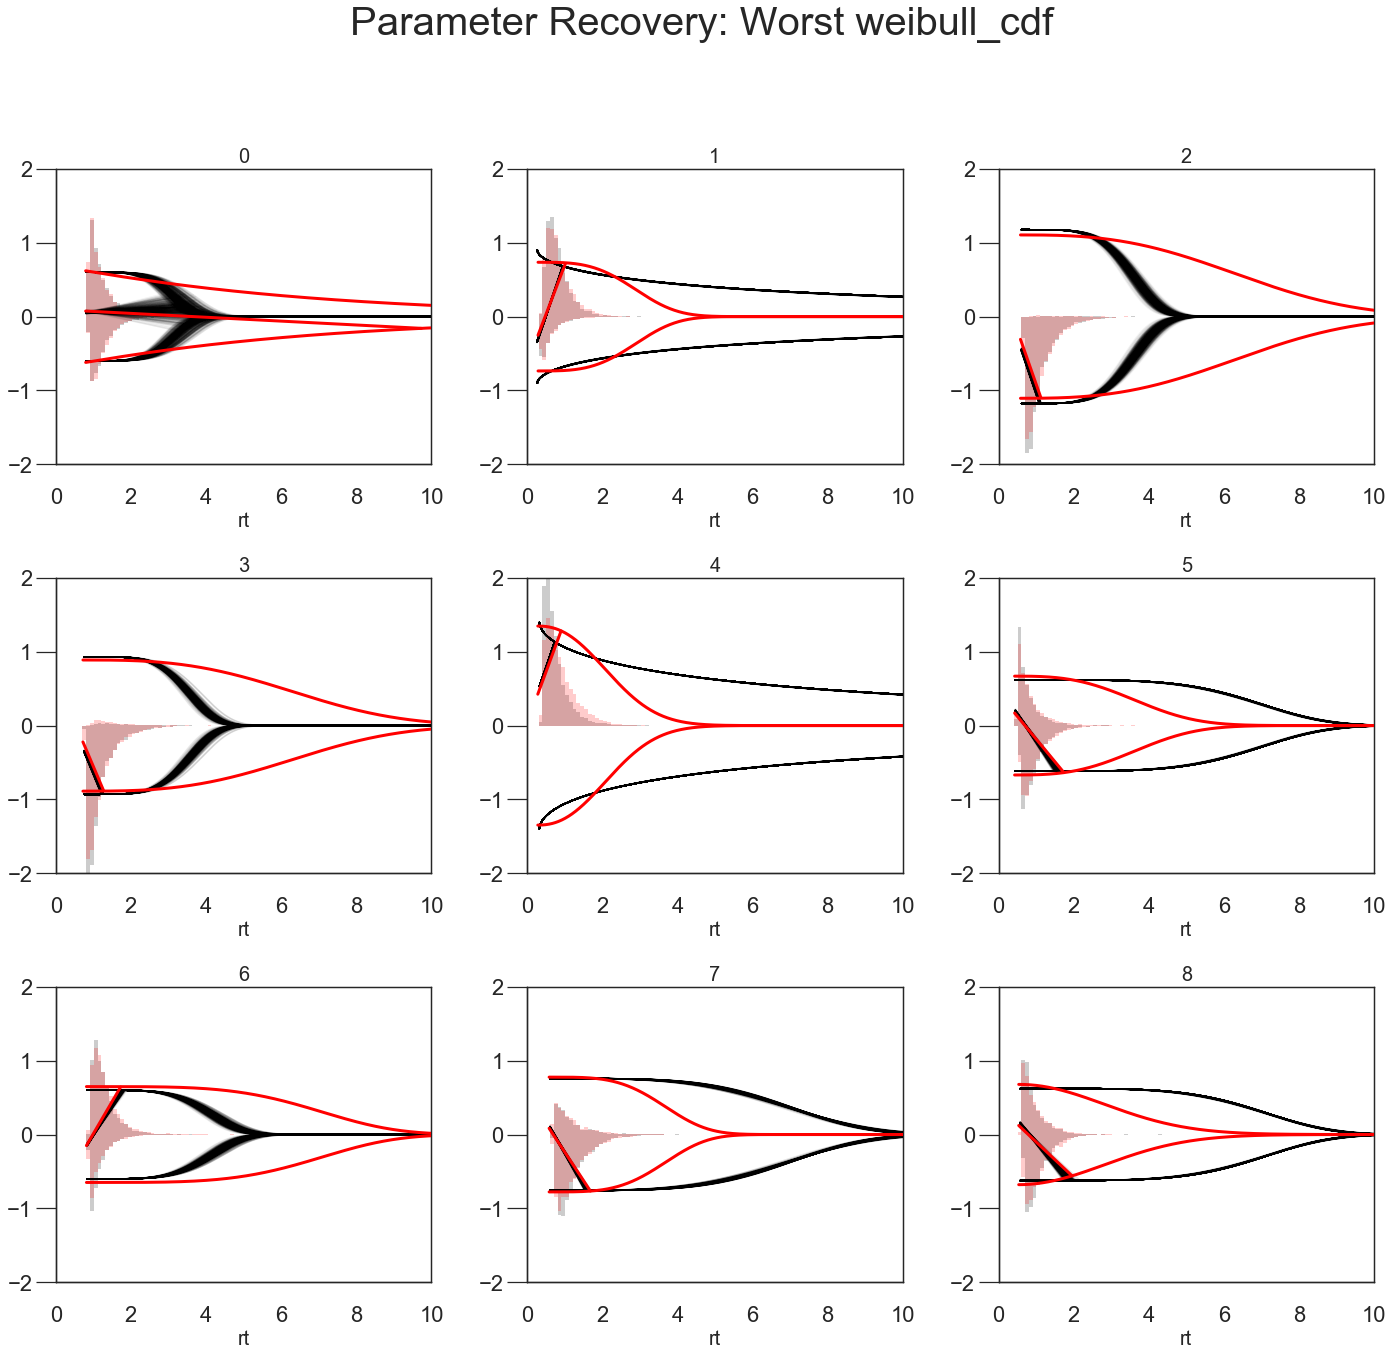

In [66]:
boundary_posterior_plot(ax_titles = [str(i) for i in range(9)], 
                        title = 'Parameter Recovery: Worst ',
                        posterior_parameters = dat_total[1][top_idx, 5000:, :],
                        data = dat_total[0][top_idx, :],
                        cols = 3,
                        model = 'weibull_cdf',
                        figure_name = 'bg_posterior_bounds',
                        n_post_params = 500,
                        max_t = 10,
                        show = True,
                        save = False)

array([-1.49997396,  1.15658054,  0.31063246,  0.61755515,  4.93947995,
        3.23996792])